# Предсказание цены автомобиля

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
from catboost import CatBoostRegressor, Pool, cv

In [2]:
data = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
display(data.head(3))
print(data.info())
print(test.info())

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,sellingprice,saledate
0,2011,Ford,Edge,SEL,suv,automatic,2fmdk3jc4bba41556,md,4.2,111041.0,black,black,santander consumer,12500,Tue Jun 02 2015 02:30:00 GMT-0700 (PDT)
1,2014,Ford,Fusion,SE,Sedan,automatic,3fa6p0h75er208976,mo,3.5,31034.0,black,black,ars/avis budget group,14500,Wed Feb 25 2015 02:00:00 GMT-0800 (PST)
2,2012,Nissan,Sentra,2.0 SL,sedan,automatic,3n1ab6ap4cl698412,nj,2.2,35619.0,black,black,nissan-infiniti lt,9100,Wed Jun 10 2015 02:30:00 GMT-0700 (PDT)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440236 entries, 0 to 440235
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          440236 non-null  int64  
 1   make          432193 non-null  object 
 2   model         432113 non-null  object 
 3   trim          431899 non-null  object 
 4   body          429843 non-null  object 
 5   transmission  388775 non-null  object 
 6   vin           440236 non-null  object 
 7   state         440236 non-null  object 
 8   condition     430831 non-null  float64
 9   odometer      440167 non-null  float64
 10  color         439650 non-null  object 
 11  interior      439650 non-null  object 
 12  seller        440236 non-null  object 
 13  sellingprice  440236 non-null  int64  
 14  saledate      440236 non-null  object 
dtypes: float64(2), int64(2), object(11)
memory usage: 50.4+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110058 entries, 0 to 1

В данных есть пропуски. Есть столбец с датой продажи в неудобном формате. Для анализа могут быть полезны день, месяц и год продажи авто, так что можно создать новые колонки:

In [3]:
# дата в формате "Tue Jun 02 2015 02:30:00 GMT-0700 (PDT)"
data['saledate'] = pd.to_datetime(data['saledate'], format='%a %b %d %Y %H:%M:%S GMT%z',\
                              exact=False, utc=True)
test['saledate'] = pd.to_datetime(test['saledate'], format='%a %b %d %Y %H:%M:%S GMT%z',\
                              exact=False, utc=True)
data['saleday'], test['saleday'] = data['saledate'].dt.day, test['saledate'].dt.day
data['salemonth'], test['salemonth'] = data['saledate'].dt.month, test['saledate'].dt.month
data['saleyear'], test['saleyear'] = data['saledate'].dt.year, test['saledate'].dt.year

data = data.drop('saledate', axis=1)
test = test.drop('saledate', axis=1)
data.head(3)

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,sellingprice,saleday,salemonth,saleyear
0,2011,Ford,Edge,SEL,suv,automatic,2fmdk3jc4bba41556,md,4.2,111041.0,black,black,santander consumer,12500,2,6,2015
1,2014,Ford,Fusion,SE,Sedan,automatic,3fa6p0h75er208976,mo,3.5,31034.0,black,black,ars/avis budget group,14500,25,2,2015
2,2012,Nissan,Sentra,2.0 SL,sedan,automatic,3n1ab6ap4cl698412,nj,2.2,35619.0,black,black,nissan-infiniti lt,9100,10,6,2015


## Обработка категориальных признаков

В категориальных признаках много пропусков, но заполнить их значениями не получится - ни для производителя, ни для параметров авто нет логичной замены.

In [4]:
# заполняем пропуски заглушками
data['make'], test['make'] = \
        data['make'].fillna(''), test['make'].fillna('')
data['body'], test['body'] = \
        data['body'].fillna(''), test['body'].fillna('')
data['trim'], test['trim']  = \
        data['trim'].fillna(''), test['trim'].fillna('')
data['model'], test['model']  = \
        data['model'].fillna(''), test['model'].fillna('')
data['color'], test['color']  = \
        data['color'].fillna(''), test['color'].fillna('')
data['interior'], test['interior']  = \
        data['interior'].fillna(''), test['interior'].fillna('')
data['transmission'], test['transmission'] = \
        data['transmission'].fillna(''), test['transmission'].fillna('')

In [5]:
for n in data.select_dtypes(include=['object']).columns:
    print(n)
    print(data[n].sort_values().unique())

make
['' 'Acura' 'Aston Martin' 'Audi' 'BMW' 'Bentley' 'Buick' 'Cadillac'
 'Chevrolet' 'Chrysler' 'Daewoo' 'Dodge' 'FIAT' 'Ferrari' 'Fisker' 'Ford'
 'GMC' 'Geo' 'HUMMER' 'Honda' 'Hyundai' 'Infiniti' 'Isuzu' 'Jaguar' 'Jeep'
 'Kia' 'Lamborghini' 'Land Rover' 'Lexus' 'Lincoln' 'MINI' 'Maserati'
 'Mazda' 'Mercedes-Benz' 'Mercury' 'Mitsubishi' 'Nissan' 'Oldsmobile'
 'Plymouth' 'Pontiac' 'Porsche' 'Ram' 'Rolls-Royce' 'Saab' 'Saturn'
 'Scion' 'Subaru' 'Suzuki' 'Tesla' 'Toyota' 'Volkswagen' 'Volvo' 'acura'
 'airstream' 'audi' 'bmw' 'buick' 'cadillac' 'chevrolet' 'chrysler'
 'dodge' 'dodge tk' 'dot' 'ford' 'ford truck' 'gmc' 'gmc truck' 'honda'
 'hyundai' 'jeep' 'kia' 'land rover' 'landrover' 'lexus' 'lincoln'
 'maserati' 'mazda' 'mazda tk' 'mercedes' 'mercedes-b' 'mercury'
 'mitsubishi' 'nissan' 'oldsmobile' 'plymouth' 'pontiac' 'porsche' 'smart'
 'subaru' 'suzuki' 'toyota' 'volkswagen' 'vw']
model
['' '1 Series' '1500' '190-Class' '2 Series' '200' '200SX' '2500' '3'
 '3 Series' '3 Series Gran

['' '!' '& coun fwd' ... 'yuk xl 4x2 slt' 'z06' 'zx3']
body
['' 'Access Cab' 'Beetle Convertible' 'CTS Coupe' 'CTS Wagon'
 'CTS-V Coupe' 'CTS-V Wagon' 'Cab Plus' 'Cab Plus 4' 'Club Cab'
 'Convertible' 'Coupe' 'Crew Cab' 'CrewMax Cab' 'Double Cab'
 'E-Series Van' 'Elantra Coupe' 'Extended Cab' 'G Convertible' 'G Coupe'
 'G Sedan' 'G37 Convertible' 'G37 Coupe' 'Genesis Coupe'
 'GranTurismo Convertible' 'Hatchback' 'King Cab' 'Koup' 'Mega Cab'
 'Minivan' 'Promaster Cargo Van' 'Q60 Convertible' 'Q60 Coupe' 'Quad Cab'
 'Ram Van' 'Regular Cab' 'SUV' 'Sedan' 'SuperCab' 'SuperCrew'
 'TSX Sport Wagon' 'Transit Van' 'Van' 'Wagon' 'Xtracab' 'access cab'
 'beetle convertible' 'cab plus 4' 'club cab' 'convertible' 'coupe'
 'crew cab' 'crewmax cab' 'cts coupe' 'cts-v coupe' 'double cab'
 'e-series van' 'elantra coupe' 'extended cab' 'g convertible' 'g coupe'
 'g sedan' 'g37 convertible' 'g37 coupe' 'genesis coupe'
 'granturismo convertible' 'hatchback' 'king cab' 'koup' 'mega cab'
 'minivan' 'promas

В столбцах `seller`, `model` и `trim` слишком много разных уникальных значений - проводить над ними анализ будет затруднительно, а обучать модель может быть бесполезно.
 
В остальных признаках есть неявные дубликаты, их следует обработать.

In [6]:
data['make'] = data['make'].str.lower().replace(
    ['dodge tk', 'ford truck', 'gmc', 'gmc truck',
     'Landrover', 'mazda tk', 'mercedes', 'mercedes-b', 'vw'], 
    ['dodge', 'ford', 'gmc', 'gmc',
     'land rover', 'mazda', 'mercedes-benz', 'mercedes-benz', 'volkswagen'])
test['make'] = test['make'].str.lower()
print(data['make'].sort_values().unique())

['' 'acura' 'airstream' 'aston martin' 'audi' 'bentley' 'bmw' 'buick'
 'cadillac' 'chevrolet' 'chrysler' 'daewoo' 'dodge' 'dot' 'ferrari' 'fiat'
 'fisker' 'ford' 'geo' 'gmc' 'honda' 'hummer' 'hyundai' 'infiniti' 'isuzu'
 'jaguar' 'jeep' 'kia' 'lamborghini' 'land rover' 'landrover' 'lexus'
 'lincoln' 'maserati' 'mazda' 'mercedes-benz' 'mercury' 'mini'
 'mitsubishi' 'nissan' 'oldsmobile' 'plymouth' 'pontiac' 'porsche' 'ram'
 'rolls-royce' 'saab' 'saturn' 'scion' 'smart' 'subaru' 'suzuki' 'tesla'
 'toyota' 'volkswagen' 'volvo']


In [7]:
def rename(data):
    if 'cab' in data:
        data = 'cab'
    if 'convertible' in data:
        data = 'convertible'
    if 'coupe' in data or 'koup' in data:
        data = 'coupe'
    if 'suv' in data:
        data = 'suv'
    if 'sedan' in data:
        data = 'sedan'
    if 'wagon' in data:
        data = 'wagon'
    if 'van' in data and not 'minivan' in data:
        data = 'van'
    return data

data['body'] = data['body'].str.lower().apply(rename)
test['body'] = test['body'].str.lower().apply(rename)

data['body'].sort_values().unique()

array(['', 'cab', 'convertible', 'coupe', 'hatchback', 'minivan', 'sedan',
       'supercrew', 'suv', 'van', 'wagon'], dtype=object)

In [8]:
data['color'], test['color'] = data['color'].replace('—', ''), test['color'].replace('—', '')
data['interior'], test['interior'] = data['interior'].replace('—', ''), test['interior'].replace('—', '')

In [9]:
data['trim'] = data['trim'].str.lower()
test['trim'] = test['trim'].str.lower()
data['model'] = data['model'].str.lower()
test['model'] = test['model'].str.lower()

Теперь можно проверить, есть ли в признаках малочисленные категории.

In [10]:
print(data['make'].value_counts())
print(data['body'].value_counts())
print(data['state'].value_counts())
print(data['transmission'].value_counts())
print(data['color'].value_counts())
print(data['interior'].value_counts())

ford             74070
chevrolet        47818
nissan           42866
toyota           31711
dodge            24295
honda            21600
hyundai          17187
bmw              16254
kia              14325
chrysler         13796
mercedes-benz    13408
infiniti         12123
jeep             12107
volkswagen        9901
lexus             9363
gmc               8368
                  8043
mazda             6704
cadillac          5958
acura             4679
audi              4635
lincoln           4541
buick             4023
subaru            4019
pontiac           3596
ram               3592
mitsubishi        3413
volvo             2958
mini              2473
saturn            2247
mercury           1561
land rover        1457
scion             1338
jaguar            1100
porsche           1094
suzuki             846
fiat               672
hummer             597
saab               384
smart              311
oldsmobile         294
isuzu              163
maserati           112
bentley    

В `make` есть категории, встречающиеся менее 500 раз, что очень мало для представления одной категории по сравнению с другими. Тоже самое со штатом продажи и цветом авто - заменю их на заглушки.

In [11]:
data['make'] = data['make'].replace(list(data['make'].value_counts()[data['make'].value_counts() < 500].index), '')
data['state'] = data['state'].replace(list(data['state'].value_counts()[data['state'].value_counts() < 500].index), '')
data['color'] = data['color'].replace(list(data['color'].value_counts()[data['color'].value_counts() < 500].index), '')
data['interior'] = data['interior'].replace(list(data['interior'].value_counts()[data['interior'].value_counts() < 500].index), '')

## Обработка числовых признаков

In [12]:
data.describe()

,year,condition,odometer,sellingprice,saleday,salemonth,saleyear
count,440236.000000,430831.000000,440167.000000,440236.000000,440236.000000,440236.000000,440236.000000
mean,2010.040101,3.425077,68344.421604,13592.209588,15.423720,3.817561,2014.902516
std,3.977945,0.949973,53542.203908,9751.479098,8.541039,3.245565,0.296616
min,1982.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2014.000000
25%,2007.000000,2.700000,28258.000000,6900.000000,8.000000,1.000000,2015.000000
50%,2012.000000,3.600000,52098.000000,12100.000000,16.000000,2.000000,2015.000000
75%,2013.000000,4.200000,99272.000000,18200.000000,22.000000,6.000000,2015.000000
max,2015.000000,5.000000,999999.000000,230000.000000,31.000000,12.000000,2015.000000


В столбцах с пробегом и ценой есть очень маленькие и большие значения.

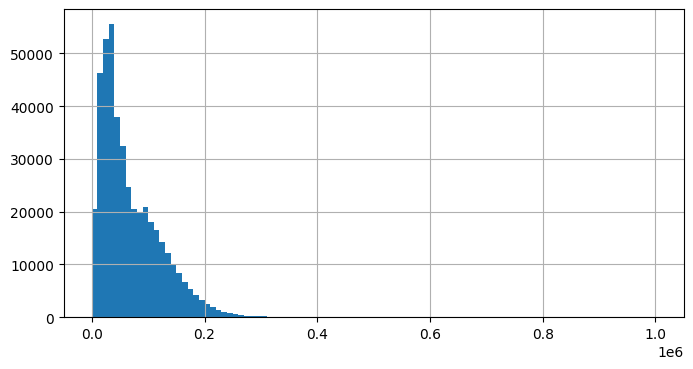

In [13]:
data['odometer'].hist(bins=100, figsize=(8, 4));

In [14]:
print(data[data['odometer'] < 20000]['odometer'].value_counts(bins=20).sort_index())
print(data[data['odometer'] > 100000]['odometer'].value_counts(bins=20).sort_index())

(-18.999000000000002, 1000.9]    2041
(1000.9, 2000.8]                  853
(2000.8, 3000.7]                 1129
(3000.7, 4000.6]                 1476
(4000.6, 5000.5]                 1664
(5000.5, 6000.4]                 1955
(6000.4, 7000.3]                 2278
(7000.3, 8000.2]                 2642
(8000.2, 9000.1]                 2976
(9000.1, 10000.0]                3430
(10000.0, 10999.9]               3520
(10999.9, 11999.8]               3808
(11999.8, 12999.7]               4278
(12999.7, 13999.6]               4352
(13999.6, 14999.5]               4653
(14999.5, 15999.4]               4773
(15999.4, 16999.3]               4952
(16999.3, 17999.2]               5151
(17999.2, 18999.1]               5365
(18999.1, 19999.0]               5526
Name: odometer, dtype: int64
(99101.00099999999, 145000.9]    66290
(145000.9, 190000.8]             29258
(190000.8, 235000.7]              9426
(235000.7, 280000.6]              2479
(280000.6, 325000.5]               691
(325000.5, 37000

Значения пробега менее 30 тыс. распределены равномерно, а вот большие значения похожи на выбросы, их стоит удалить.

In [15]:
data = data.drop(data[data['odometer'] > 300000].index)

(-3.975, 249.7]      281
(249.7, 498.4]      3929
(498.4, 747.1]      4507
(747.1, 995.8]      3677
(995.8, 1244.5]     5021
(1244.5, 1493.2]    3535
(1493.2, 1741.9]    5343
(1741.9, 1990.6]    3352
(1990.6, 2239.3]    5323
(2239.3, 2488.0]    3358
(2488.0, 2736.7]    5581
(2736.7, 2985.4]    3334
(2985.4, 3234.1]    5477
(3234.1, 3482.8]    3260
(3482.8, 3731.5]    5284
(3731.5, 3980.2]    3228
(3980.2, 4228.9]    5533
(4228.9, 4477.6]    2931
(4477.6, 4726.3]    4905
(4726.3, 4975.0]    2754
Name: sellingprice, dtype: int64
(39835.024000000005, 49523.75]    4382
(49523.75, 59022.5]               1470
(59022.5, 68521.25]                568
(68521.25, 78020.0]                350
(78020.0, 87518.75]                200
(87518.75, 97017.5]                 88
(97017.5, 106516.25]                48
(106516.25, 116015.0]               30
(116015.0, 125513.75]               24
(125513.75, 135012.5]               11
(135012.5, 144511.25]               11
(144511.25, 154010.0]                8

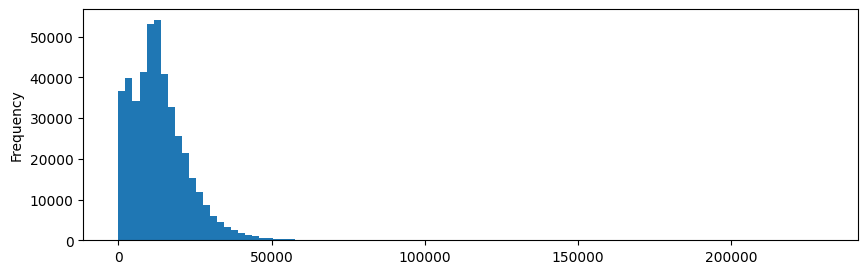

In [16]:
data['sellingprice'].plot(kind='hist', bins=100, figsize=(10, 3));
print(data[data['sellingprice'] < 5000]['sellingprice'].value_counts(bins=20).sort_index())
print(data[data['sellingprice'] > 40000]['sellingprice'].value_counts(bins=20).sort_index())

In [17]:
data = data.drop(data[data['sellingprice'] > 80000].index)
data = data.drop(data[data['sellingprice'] < 250].index)

Также с ценой - странные маленькие и большие значения удалены.

In [18]:
print(data['year'].value_counts())
data = data.drop(data[data['year'] < 1997].index)

2012    80578
2013    77476
2014    64064
2011    38085
2008    24601
2007    24109
2006    21067
2010    20606
2005    16741
2009    16027
2004    13609
2003    10439
2002     7650
2015     7417
2001     5076
2000     4103
1999     2587
1998     1696
1997     1167
1996      659
1995      545
1994      298
1993      153
1992       95
1991       52
1990       35
1989       12
1988       10
1985       10
1986        8
1987        5
1984        4
1983        1
1982        1
Name: year, dtype: int64


В столбце с годом производства некоторые года встречаются слишком редко, чтобы построить по ним полную картину продаж в этот год.

## Исследовательский анализ данных

Теперь, когда основная часть данных обработана, можно оценить от каких параметров авто зависит цена и поискать другие зависимости в признаках.

In [19]:
# функция для отображения графиков
def price_graphs(data, column, values, desc, figsize):
    d = data.pivot_table(index=column, values=[values],
                         aggfunc='mean').reset_index()
    ax = plt.subplot()
    d[values].plot(kind='bar', figsize=figsize, alpha=0.8, grid=True)
    ax.set_xticklabels(d[column].sort_values().unique())
    plt.xlabel(desc)
    plt.show()

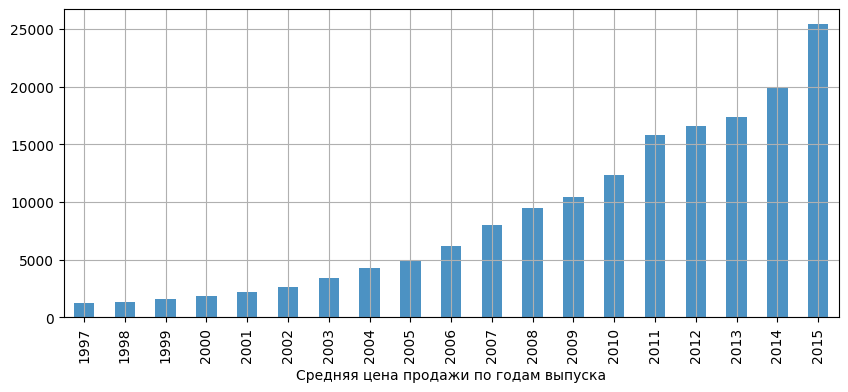

In [20]:
price_graphs(data, 'year', 'sellingprice', 'Средняя цена продажи по годам выпуска', (10, 4))

Похоже, что чем новее авто, тем дороже.

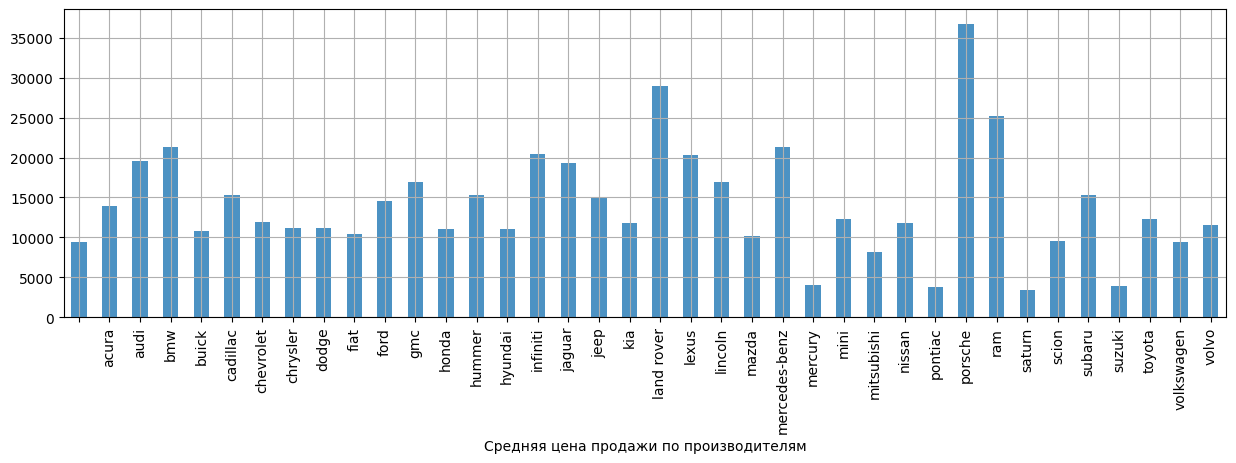

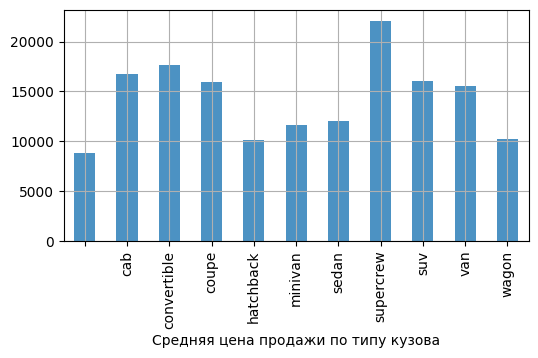

In [21]:
price_graphs(data, 'make', 'sellingprice', 'Средняя цена продажи по производителям', (15, 4))
price_graphs(data, 'body', 'sellingprice', 'Средняя цена продажи по типу кузова', (6, 3))

Производитель влияет на цену - некоторые марки продаются в среднем более чем за 25000, некоторые - менее чем за 5000. Тип кузова также сильно влияет на цену.

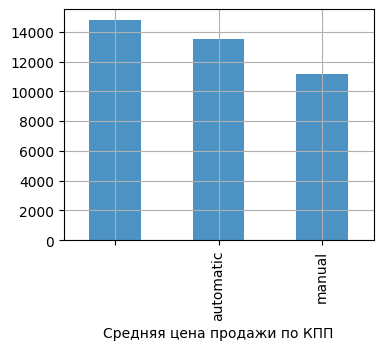

In [22]:
price_graphs(data, 'transmission', 'sellingprice', 'Средняя цена продажи по КПП', (4, 3))

У автоматической КПП цена в среднем чуть больше чем у ручной. Цена машин, у которых не указана КПП, больше, чем у автоматики - большая часть из них, наверное, и есть с автоматикой.

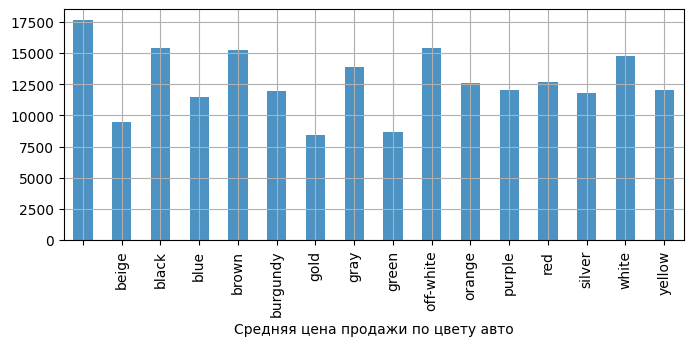

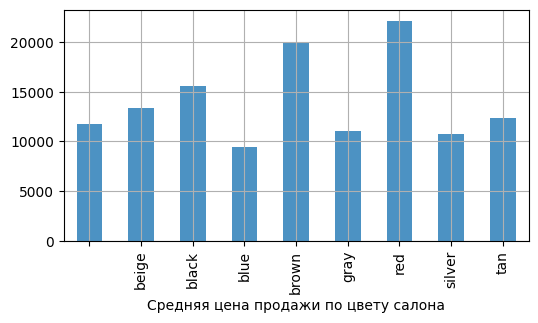

In [23]:
price_graphs(data, 'color', 'sellingprice', 'Средняя цена продажи по цвету авто', (8, 3))
price_graphs(data, 'interior', 'sellingprice', 'Средняя цена продажи по цвету салона', (6, 3))

В некоторых случаях цена может отличаться в два раза в зависимости от цвета авто и салона.

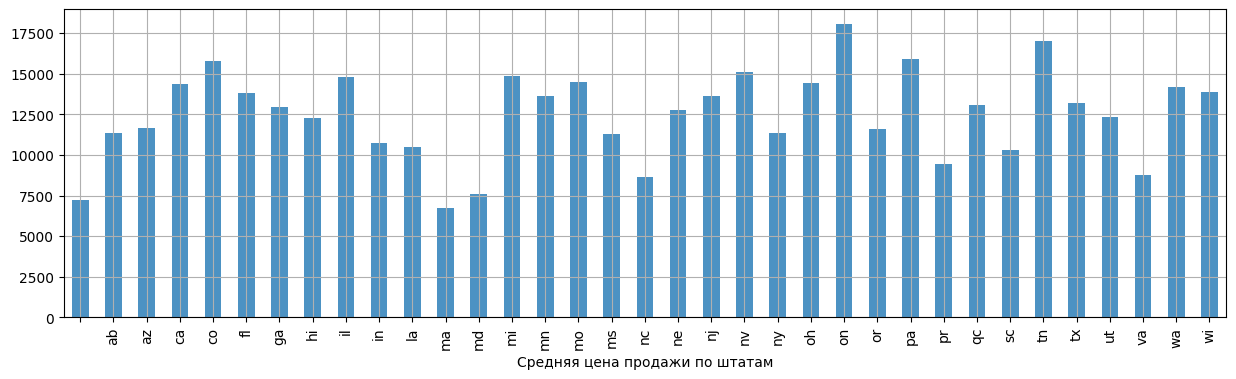

In [24]:
price_graphs(data, 'state', 'sellingprice', 'Средняя цена продажи по штатам', (15, 4))

Цена также сильно изменяется от штата к штату.

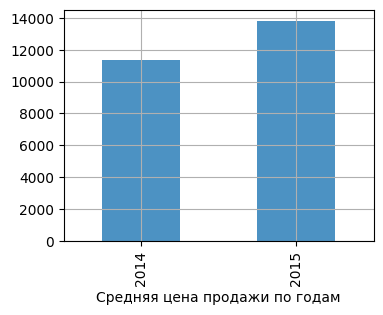

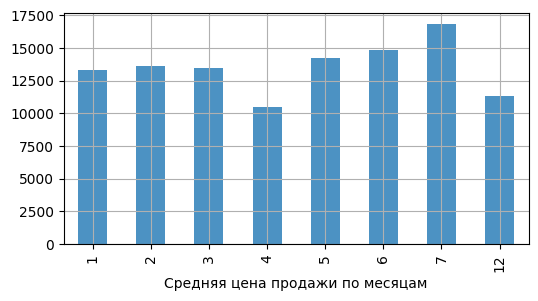

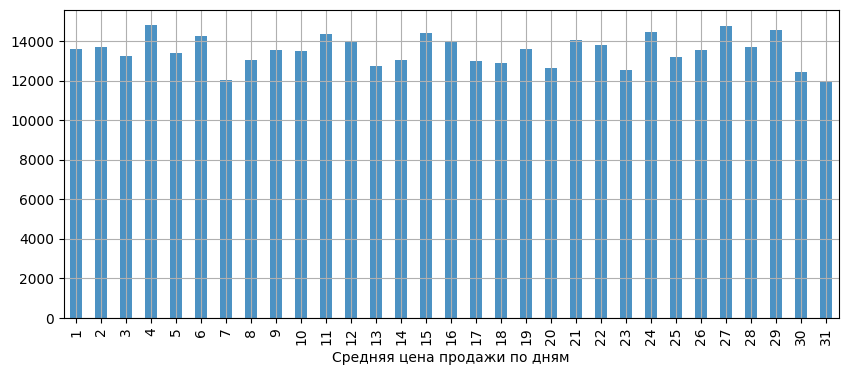

In [25]:
price_graphs(data, 'saleyear', 'sellingprice', 'Средняя цена продажи по годам', (4, 3))
price_graphs(data, 'salemonth', 'sellingprice', 'Средняя цена продажи по месяцам', (6, 3))
price_graphs(data, 'saleday', 'sellingprice', 'Средняя цена продажи по дням', (10, 4))

Есть информация только о 2014 и 2015 годах продажи - по ним многого не скажешь. Месяцы представлены не все в году.   
Зависимости от времени продажи не видно.

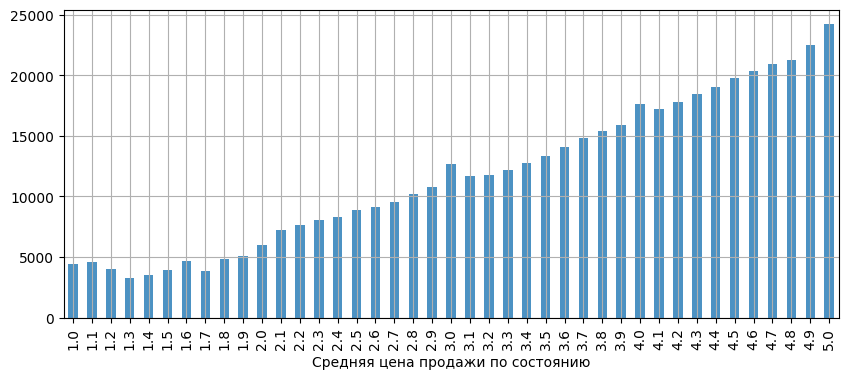

In [26]:
price_graphs(data, 'condition', 'sellingprice',  'Средняя цена продажи по состоянию', (10, 4))

Судя по графику, цена зависит от состояния авто почти напрямую.

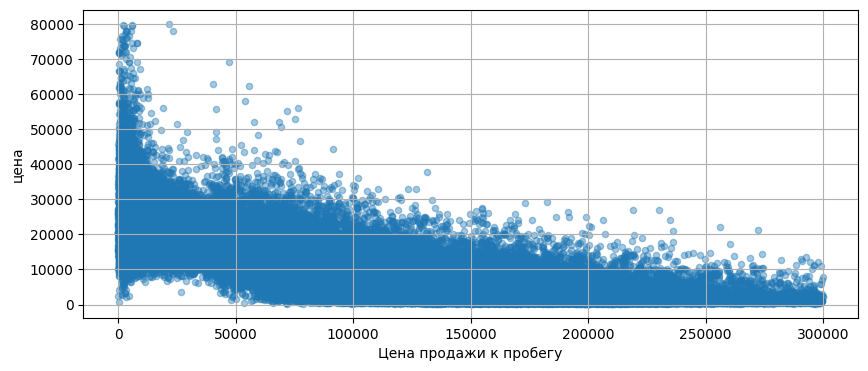

In [27]:
d = data.pivot_table(index='odometer', values=['sellingprice']).reset_index()

d.plot(kind='scatter', x='odometer', y='sellingprice', figsize=(10, 4), alpha=0.4, grid=True)
plt.ylabel('цена')
plt.xlabel('Цена продажи к пробегу')
plt.show()

С пробегом также - чем меньше пробег, тем обычно больше цена. Состояние должно быть связано с пробегом.

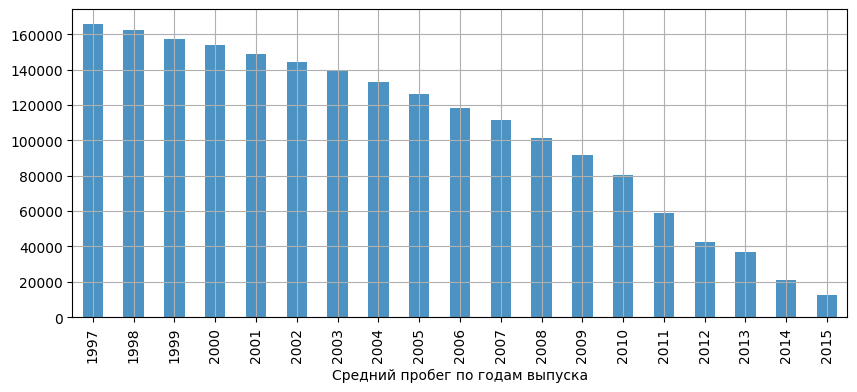

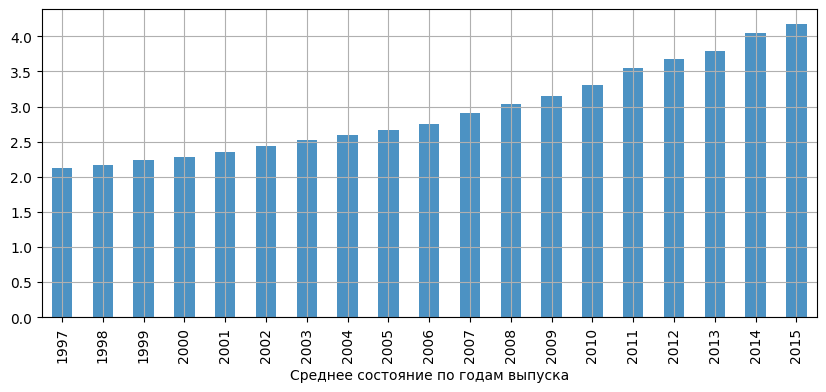

In [28]:
price_graphs(data, 'year', 'odometer', 'Средний пробег по годам выпуска', (10, 4))
price_graphs(data, 'year', 'condition', 'Среднее состояние по годам выпуска', (10, 4))

Тут все логично - чем новее автомобиль, тем, скорее всего, меньше у него будет пробег, а состояние будет лучше.

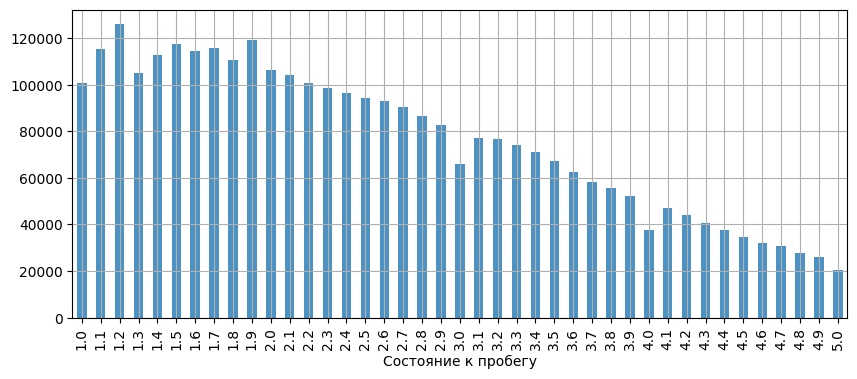

In [29]:
price_graphs(data, 'condition', 'odometer', 'Состояние к пробегу', (10, 4))

И тут ожидаемо - чем меньше пробег, тем в среднем лучше состояние.

Судя по изученным графикам для модели могут быть бесполезны время продажи и тип КПП.

## Обработка пробега и состояния

In [30]:
data.isna().sum()

year               0
make               0
model              0
trim               0
body               0
transmission       0
vin                0
state              0
condition       9190
odometer          66
color              0
interior           0
seller             0
sellingprice       0
saleday            0
salemonth          0
saleyear           0
dtype: int64

В пробеге и состоянии еще остались пропуски. По анализу видна их зависимость от возраста авто, так что их можно заполнить средним значением по году выпуска.

In [31]:
years = data.pivot_table(index='year', values=['sellingprice', 'condition', 'odometer'],
                         aggfunc='mean').reset_index()
years['condition'] = round(years['condition'], 1)
years['odometer'] = round(years['odometer'], 0)

def years_fill(d, years):
    if np.isnan(d['condition']):
        d['condition'] = years[years['year'] == d['year']]['condition'].values[0]
    if np.isnan(d['odometer']):
        d['odometer'] = years[years['year'] == d['year']]['odometer'].values[0]
    return d

data = data.apply(years_fill, years=years, axis=1)

In [32]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 437098 entries, 0 to 440235
Data columns (total 17 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          437098 non-null  int64  
 1   make          437098 non-null  object 
 2   model         437098 non-null  object 
 3   trim          437098 non-null  object 
 4   body          437098 non-null  object 
 5   transmission  437098 non-null  object 
 6   vin           437098 non-null  object 
 7   state         437098 non-null  object 
 8   condition     437098 non-null  float64
 9   odometer      437098 non-null  float64
 10  color         437098 non-null  object 
 11  interior      437098 non-null  object 
 12  seller        437098 non-null  object 
 13  sellingprice  437098 non-null  int64  
 14  saleday       437098 non-null  int64  
 15  salemonth     437098 non-null  int64  
 16  saleyear      437098 non-null  int64  
dtypes: float64(2), int64(5), object(10)
memory usage

Теперь все данные в порядке, можно строить модель.

## Базовая модель

Для обучения модели не нужен VIN-номер. Могут быть бесполезны данные о времени продажи, продавцах, моделях авто и модификациях, но это еще нужно проверить.

In [33]:
ddata = data.drop(['vin'], axis=1)
dtest = test.drop(['vin'], axis=1)
display(ddata.head(1))
dtest.head(1)

,year,make,model,trim,body,transmission,state,condition,odometer,color,interior,seller,sellingprice,saleday,salemonth,saleyear
0,2011,ford,edge,sel,suv,automatic,md,4.2,111041.0,black,black,santander consumer,12500,2,6,2015


,year,make,model,trim,body,transmission,state,condition,odometer,color,interior,seller,saleday,salemonth,saleyear
0,2005,cadillac,cts,base,sedan,automatic,ca,2.7,116970.0,silver,black,lexus of stevens creek,14,1,2015


Разделю данные из датасета `train` на обучающую и тестовую выборку и обучу базовую регрессионную модель CatBoost:

In [34]:
feat_train = ddata.drop(['sellingprice'], axis=1)
targ_train = ddata['sellingprice']

X_train, X_test, y_train, y_test = train_test_split(feat_train, targ_train,
                                                    train_size=0.8,random_state=42)

cats = ['make', 'model', 'trim', 'body', 'transmission', 'state', 'color', 'interior', 'seller']
p_train = Pool(X_train, y_train, cat_features=cats)
p_test = Pool(X_test, cat_features=cats)

In [35]:
cat = CatBoostRegressor(iterations=100, loss_function='MAE', eval_metric='MAPE',
                        random_seed=42)
cat.fit(p_train)
preds = cat.predict(p_test)
mean_absolute_percentage_error(y_test, preds) * 100

0:	learn: 1.4481035	total: 358ms	remaining: 35.4s
1:	learn: 1.4131635	total: 596ms	remaining: 29.2s
2:	learn: 1.3787922	total: 878ms	remaining: 28.4s
3:	learn: 1.3473596	total: 1.15s	remaining: 27.7s
4:	learn: 1.3149905	total: 1.38s	remaining: 26.3s
5:	learn: 1.2835071	total: 1.61s	remaining: 25.3s
6:	learn: 1.2532575	total: 1.92s	remaining: 25.5s
7:	learn: 1.2252310	total: 2.2s	remaining: 25.3s
8:	learn: 1.1969493	total: 2.55s	remaining: 25.8s
9:	learn: 1.1697625	total: 2.79s	remaining: 25.1s
10:	learn: 1.1449409	total: 3.01s	remaining: 24.3s
11:	learn: 1.1188433	total: 3.25s	remaining: 23.8s
12:	learn: 1.0939645	total: 3.46s	remaining: 23.2s
13:	learn: 1.0721988	total: 3.68s	remaining: 22.6s
14:	learn: 1.0485769	total: 3.89s	remaining: 22.1s
15:	learn: 1.0253006	total: 4.1s	remaining: 21.6s
16:	learn: 1.0044076	total: 4.31s	remaining: 21.1s
17:	learn: 0.9836481	total: 4.53s	remaining: 20.6s
18:	learn: 0.9627738	total: 4.74s	remaining: 20.2s
19:	learn: 0.9428986	total: 4.95s	remaining

32.315245719271296

МАРЕ базовой модели составила 32.3%.

In [36]:
for n in range(len(cat.feature_names_)):
    print(cat.feature_names_[n], ": ", cat.feature_importances_[n])

year :  16.34804362395665
make :  15.076607959903557
model :  17.36456768120753
trim :  10.006792605857191
body :  10.67599414631436
transmission :  0.0
state :  0.0
condition :  6.79542824669859
odometer :  23.423169005869955
color :  0.0
interior :  0.0
seller :  0.30939673019216374
saleday :  0.0
salemonth :  0.0
saleyear :  0.0


Самую большую значимость для модели имеет пробег. Модель также нашла важными модификацию и модель автомобиля, несмотря на множественные категории внутри этих признаков. Низкая значимость типа КПП и времени продажи совпала с анализом.

Признаки с нулевой и малой значимостью можно отбросить и перейти к подбору гиперпараметров.

## Подбор гиперпараметров

In [37]:
ddata = data.drop(['vin', 'transmission', 'state', 'color', 'interior', 'seller',
                   'saleday', 'salemonth', 'saleyear'], axis=1)
dtest = test.drop(['vin', 'transmission', 'state', 'color', 'interior', 'seller',
                   'saleday', 'salemonth', 'saleyear'], axis=1)
display(ddata.head(1))
dtest.head(1)

,year,make,model,trim,body,condition,odometer,sellingprice
0,2011,ford,edge,sel,suv,4.2,111041.0,12500


,year,make,model,trim,body,condition,odometer
0,2005,cadillac,cts,base,sedan,2.7,116970.0


In [38]:
feat_train = ddata.drop(['sellingprice'], axis=1)
targ_train = ddata['sellingprice']

X_train, X_test, y_train, y_test = train_test_split(feat_train, targ_train,
                                                    train_size=0.8,random_state=42)
cats = ['make', 'model', 'trim', 'body']
p_train = Pool(X_train, y_train, cat_features=cats)
p_test = Pool(X_test, cat_features=cats)

In [39]:
cat = CatBoostRegressor(loss_function='MAE', eval_metric='MAPE',
        random_seed=42, early_stopping_rounds=20)

params = {'iterations': [100],
        'learning_rate': [0.1, 0.3, 0.5, 0.7],
        'depth': [5, 7, 9],
        'l2_leaf_reg': [0.1, 0.3, 0.5]}

grid_search_result = cat.grid_search(param_grid=params, X=p_train, cv=3)

0:	learn: 0.8778696	test: 0.8775827	best: 0.8775827 (0)	total: 155ms	remaining: 15.3s
1:	learn: 0.7795907	test: 0.7785018	best: 0.7785018 (1)	total: 262ms	remaining: 12.8s
2:	learn: 0.6986931	test: 0.6975733	best: 0.6975733 (2)	total: 387ms	remaining: 12.5s
3:	learn: 0.6307972	test: 0.6295287	best: 0.6295287 (3)	total: 487ms	remaining: 11.7s
4:	learn: 0.5752735	test: 0.5740705	best: 0.5740705 (4)	total: 591ms	remaining: 11.2s
5:	learn: 0.5322691	test: 0.5315662	best: 0.5315662 (5)	total: 697ms	remaining: 10.9s
6:	learn: 0.4947289	test: 0.4942059	best: 0.4942059 (6)	total: 801ms	remaining: 10.6s
7:	learn: 0.4617719	test: 0.4609223	best: 0.4609223 (7)	total: 904ms	remaining: 10.4s
8:	learn: 0.4349529	test: 0.4337555	best: 0.4337555 (8)	total: 1.01s	remaining: 10.2s
9:	learn: 0.4127091	test: 0.4114202	best: 0.4114202 (9)	total: 1.11s	remaining: 9.99s
10:	learn: 0.3924563	test: 0.3910456	best: 0.3910456 (10)	total: 1.22s	remaining: 9.91s
11:	learn: 0.3773139	test: 0.3758429	best: 0.3758429

94:	learn: 0.2486347	test: 0.2462651	best: 0.2462651 (94)	total: 10.5s	remaining: 554ms
95:	learn: 0.2484731	test: 0.2461498	best: 0.2461498 (95)	total: 10.6s	remaining: 443ms
96:	learn: 0.2481338	test: 0.2458150	best: 0.2458150 (96)	total: 10.8s	remaining: 333ms
97:	learn: 0.2476572	test: 0.2453507	best: 0.2453507 (97)	total: 10.9s	remaining: 222ms
98:	learn: 0.2468608	test: 0.2446328	best: 0.2446328 (98)	total: 11s	remaining: 111ms
99:	learn: 0.2462678	test: 0.2439727	best: 0.2439727 (99)	total: 11.1s	remaining: 0us

bestTest = 0.2439726679
bestIteration = 99

0:	loss: 0.2439727	best: 0.2439727 (0)	total: 11.5s	remaining: 6m 43s
0:	learn: 0.6919764	test: 0.6912548	best: 0.6912548 (0)	total: 150ms	remaining: 14.9s
1:	learn: 0.5275371	test: 0.5265146	best: 0.5265146 (1)	total: 278ms	remaining: 13.6s
2:	learn: 0.4305936	test: 0.4290631	best: 0.4290631 (2)	total: 406ms	remaining: 13.1s
3:	learn: 0.3748068	test: 0.3733511	best: 0.3733511 (3)	total: 547ms	remaining: 13.1s
4:	learn: 0.34425

87:	learn: 0.2229100	test: 0.2208409	best: 0.2208409 (87)	total: 10.5s	remaining: 1.43s
88:	learn: 0.2227791	test: 0.2207835	best: 0.2207835 (88)	total: 10.6s	remaining: 1.31s
89:	learn: 0.2226741	test: 0.2204312	best: 0.2204312 (89)	total: 10.7s	remaining: 1.19s
90:	learn: 0.2224739	test: 0.2202250	best: 0.2202250 (90)	total: 10.8s	remaining: 1.07s
91:	learn: 0.2220512	test: 0.2197843	best: 0.2197843 (91)	total: 10.9s	remaining: 952ms
92:	learn: 0.2217117	test: 0.2193819	best: 0.2193819 (92)	total: 11s	remaining: 832ms
93:	learn: 0.2218150	test: 0.2195305	best: 0.2193819 (92)	total: 11.2s	remaining: 712ms
94:	learn: 0.2216815	test: 0.2194086	best: 0.2193819 (92)	total: 11.3s	remaining: 593ms
95:	learn: 0.2213297	test: 0.2189592	best: 0.2189592 (95)	total: 11.4s	remaining: 474ms
96:	learn: 0.2209789	test: 0.2187099	best: 0.2187099 (96)	total: 11.5s	remaining: 355ms
97:	learn: 0.2207934	test: 0.2184003	best: 0.2184003 (97)	total: 11.6s	remaining: 237ms
98:	learn: 0.2204731	test: 0.21807

80:	learn: 0.2244423	test: 0.2220541	best: 0.2220541 (80)	total: 9.21s	remaining: 2.16s
81:	learn: 0.2242754	test: 0.2218641	best: 0.2218641 (81)	total: 9.34s	remaining: 2.05s
82:	learn: 0.2242667	test: 0.2220632	best: 0.2218641 (81)	total: 9.45s	remaining: 1.93s
83:	learn: 0.2236428	test: 0.2213625	best: 0.2213625 (83)	total: 9.55s	remaining: 1.82s
84:	learn: 0.2229724	test: 0.2206833	best: 0.2206833 (84)	total: 9.66s	remaining: 1.7s
85:	learn: 0.2226468	test: 0.2204621	best: 0.2204621 (85)	total: 9.78s	remaining: 1.59s
86:	learn: 0.2225613	test: 0.2203261	best: 0.2203261 (86)	total: 9.88s	remaining: 1.48s
87:	learn: 0.2222141	test: 0.2199222	best: 0.2199222 (87)	total: 9.99s	remaining: 1.36s
88:	learn: 0.2219704	test: 0.2197166	best: 0.2197166 (88)	total: 10.1s	remaining: 1.25s
89:	learn: 0.2213001	test: 0.2188892	best: 0.2188892 (89)	total: 10.2s	remaining: 1.14s
90:	learn: 0.2210671	test: 0.2187157	best: 0.2187157 (90)	total: 10.3s	remaining: 1.02s
91:	learn: 0.2204237	test: 0.2182

74:	learn: 0.2271406	test: 0.2235513	best: 0.2235513 (74)	total: 8.6s	remaining: 2.87s
75:	learn: 0.2266865	test: 0.2230763	best: 0.2230763 (75)	total: 8.71s	remaining: 2.75s
76:	learn: 0.2261031	test: 0.2227634	best: 0.2227634 (76)	total: 8.82s	remaining: 2.63s
77:	learn: 0.2260842	test: 0.2227962	best: 0.2227634 (76)	total: 8.92s	remaining: 2.52s
78:	learn: 0.2249422	test: 0.2214732	best: 0.2214732 (78)	total: 9.02s	remaining: 2.4s
79:	learn: 0.2249995	test: 0.2216086	best: 0.2214732 (78)	total: 9.13s	remaining: 2.28s
80:	learn: 0.2243829	test: 0.2207602	best: 0.2207602 (80)	total: 9.24s	remaining: 2.17s
81:	learn: 0.2240478	test: 0.2203899	best: 0.2203899 (81)	total: 9.34s	remaining: 2.05s
82:	learn: 0.2236399	test: 0.2198834	best: 0.2198834 (82)	total: 9.44s	remaining: 1.93s
83:	learn: 0.2235430	test: 0.2200152	best: 0.2198834 (82)	total: 9.55s	remaining: 1.82s
84:	learn: 0.2237068	test: 0.2202034	best: 0.2198834 (82)	total: 9.65s	remaining: 1.7s
85:	learn: 0.2236465	test: 0.220124

68:	learn: 0.2607903	test: 0.2584969	best: 0.2584969 (68)	total: 7.51s	remaining: 3.37s
69:	learn: 0.2604475	test: 0.2581619	best: 0.2581619 (69)	total: 7.62s	remaining: 3.27s
70:	learn: 0.2597434	test: 0.2575108	best: 0.2575108 (70)	total: 7.73s	remaining: 3.16s
71:	learn: 0.2591116	test: 0.2568142	best: 0.2568142 (71)	total: 7.84s	remaining: 3.05s
72:	learn: 0.2584921	test: 0.2562272	best: 0.2562272 (72)	total: 7.95s	remaining: 2.94s
73:	learn: 0.2580516	test: 0.2557279	best: 0.2557279 (73)	total: 8.05s	remaining: 2.83s
74:	learn: 0.2575522	test: 0.2551523	best: 0.2551523 (74)	total: 8.18s	remaining: 2.73s
75:	learn: 0.2574560	test: 0.2550553	best: 0.2550553 (75)	total: 8.31s	remaining: 2.62s
76:	learn: 0.2568050	test: 0.2543798	best: 0.2543798 (76)	total: 8.42s	remaining: 2.51s
77:	learn: 0.2561207	test: 0.2536621	best: 0.2536621 (77)	total: 8.52s	remaining: 2.4s
78:	learn: 0.2557142	test: 0.2533265	best: 0.2533265 (78)	total: 8.62s	remaining: 2.29s
79:	learn: 0.2552570	test: 0.2529

61:	learn: 0.2339366	test: 0.2320879	best: 0.2320611 (60)	total: 6.63s	remaining: 4.06s
62:	learn: 0.2327868	test: 0.2309717	best: 0.2309717 (62)	total: 6.73s	remaining: 3.96s
63:	learn: 0.2322871	test: 0.2304013	best: 0.2304013 (63)	total: 6.83s	remaining: 3.84s
64:	learn: 0.2312793	test: 0.2292700	best: 0.2292700 (64)	total: 6.94s	remaining: 3.73s
65:	learn: 0.2305119	test: 0.2284985	best: 0.2284985 (65)	total: 7.04s	remaining: 3.63s
66:	learn: 0.2303684	test: 0.2285327	best: 0.2284985 (65)	total: 7.14s	remaining: 3.52s
67:	learn: 0.2297601	test: 0.2279635	best: 0.2279635 (67)	total: 7.25s	remaining: 3.41s
68:	learn: 0.2296486	test: 0.2279359	best: 0.2279359 (68)	total: 7.35s	remaining: 3.3s
69:	learn: 0.2288509	test: 0.2270564	best: 0.2270564 (69)	total: 7.45s	remaining: 3.19s
70:	learn: 0.2286133	test: 0.2269109	best: 0.2269109 (70)	total: 7.55s	remaining: 3.08s
71:	learn: 0.2287164	test: 0.2270320	best: 0.2269109 (70)	total: 7.66s	remaining: 2.98s
72:	learn: 0.2279327	test: 0.2262

54:	learn: 0.2321191	test: 0.2300298	best: 0.2300298 (54)	total: 5.9s	remaining: 4.83s
55:	learn: 0.2320419	test: 0.2298985	best: 0.2298985 (55)	total: 6s	remaining: 4.72s
56:	learn: 0.2317888	test: 0.2297357	best: 0.2297357 (56)	total: 6.11s	remaining: 4.61s
57:	learn: 0.2311359	test: 0.2290646	best: 0.2290646 (57)	total: 6.21s	remaining: 4.49s
58:	learn: 0.2309899	test: 0.2288152	best: 0.2288152 (58)	total: 6.31s	remaining: 4.38s
59:	learn: 0.2308475	test: 0.2288772	best: 0.2288152 (58)	total: 6.41s	remaining: 4.27s
60:	learn: 0.2301903	test: 0.2282314	best: 0.2282314 (60)	total: 6.51s	remaining: 4.16s
61:	learn: 0.2316652	test: 0.2298196	best: 0.2282314 (60)	total: 6.61s	remaining: 4.05s
62:	learn: 0.2314660	test: 0.2296639	best: 0.2282314 (60)	total: 6.71s	remaining: 3.94s
63:	learn: 0.2308191	test: 0.2290200	best: 0.2282314 (60)	total: 6.82s	remaining: 3.84s
64:	learn: 0.2305302	test: 0.2285998	best: 0.2282314 (60)	total: 6.93s	remaining: 3.73s
65:	learn: 0.2297972	test: 0.2277300

48:	learn: 0.2371650	test: 0.2331567	best: 0.2331567 (48)	total: 5.34s	remaining: 5.56s
49:	learn: 0.2367925	test: 0.2326776	best: 0.2326776 (49)	total: 5.45s	remaining: 5.45s
50:	learn: 0.2362939	test: 0.2322206	best: 0.2322206 (50)	total: 5.56s	remaining: 5.34s
51:	learn: 0.2356059	test: 0.2314864	best: 0.2314864 (51)	total: 5.67s	remaining: 5.23s
52:	learn: 0.2352744	test: 0.2311179	best: 0.2311179 (52)	total: 5.77s	remaining: 5.12s
53:	learn: 0.2347984	test: 0.2308430	best: 0.2308430 (53)	total: 5.88s	remaining: 5s
54:	learn: 0.2343120	test: 0.2302812	best: 0.2302812 (54)	total: 5.98s	remaining: 4.89s
55:	learn: 0.2336386	test: 0.2295635	best: 0.2295635 (55)	total: 6.09s	remaining: 4.78s
56:	learn: 0.2333839	test: 0.2295086	best: 0.2295086 (56)	total: 6.19s	remaining: 4.67s
57:	learn: 0.2326089	test: 0.2286536	best: 0.2286536 (57)	total: 6.29s	remaining: 4.56s
58:	learn: 0.2324266	test: 0.2284165	best: 0.2284165 (58)	total: 6.4s	remaining: 4.45s
59:	learn: 0.2319540	test: 0.2277401

41:	learn: 0.2763830	test: 0.2748542	best: 0.2748542 (41)	total: 4.46s	remaining: 6.16s
42:	learn: 0.2754658	test: 0.2739379	best: 0.2739379 (42)	total: 4.56s	remaining: 6.05s
43:	learn: 0.2748456	test: 0.2728530	best: 0.2728530 (43)	total: 4.66s	remaining: 5.94s
44:	learn: 0.2742909	test: 0.2722783	best: 0.2722783 (44)	total: 4.76s	remaining: 5.82s
45:	learn: 0.2735060	test: 0.2715791	best: 0.2715791 (45)	total: 4.86s	remaining: 5.71s
46:	learn: 0.2727815	test: 0.2709043	best: 0.2709043 (46)	total: 4.96s	remaining: 5.6s
47:	learn: 0.2723073	test: 0.2704824	best: 0.2704824 (47)	total: 5.07s	remaining: 5.49s
48:	learn: 0.2714724	test: 0.2696207	best: 0.2696207 (48)	total: 5.17s	remaining: 5.38s
49:	learn: 0.2706328	test: 0.2686971	best: 0.2686971 (49)	total: 5.27s	remaining: 5.27s
50:	learn: 0.2697526	test: 0.2678075	best: 0.2678075 (50)	total: 5.37s	remaining: 5.16s
51:	learn: 0.2690796	test: 0.2670925	best: 0.2670925 (51)	total: 5.47s	remaining: 5.05s
52:	learn: 0.2683556	test: 0.2662

35:	learn: 0.2519747	test: 0.2494408	best: 0.2494408 (35)	total: 3.87s	remaining: 6.88s
36:	learn: 0.2505661	test: 0.2480567	best: 0.2480567 (36)	total: 3.97s	remaining: 6.76s
37:	learn: 0.2504605	test: 0.2482227	best: 0.2480567 (36)	total: 4.08s	remaining: 6.65s
38:	learn: 0.2502663	test: 0.2480136	best: 0.2480136 (38)	total: 4.18s	remaining: 6.54s
39:	learn: 0.2497488	test: 0.2472904	best: 0.2472904 (39)	total: 4.29s	remaining: 6.43s
40:	learn: 0.2491136	test: 0.2466030	best: 0.2466030 (40)	total: 4.39s	remaining: 6.32s
41:	learn: 0.2472786	test: 0.2445630	best: 0.2445630 (41)	total: 4.49s	remaining: 6.21s
42:	learn: 0.2454865	test: 0.2434099	best: 0.2434099 (42)	total: 4.59s	remaining: 6.09s
43:	learn: 0.2445774	test: 0.2424080	best: 0.2424080 (43)	total: 4.7s	remaining: 5.98s
44:	learn: 0.2436294	test: 0.2415425	best: 0.2415425 (44)	total: 4.8s	remaining: 5.87s
45:	learn: 0.2427247	test: 0.2407054	best: 0.2407054 (45)	total: 4.9s	remaining: 5.75s
46:	learn: 0.2424718	test: 0.240587

28:	learn: 0.2532430	test: 0.2515456	best: 0.2515456 (28)	total: 3.23s	remaining: 7.91s
29:	learn: 0.2524110	test: 0.2508292	best: 0.2508292 (29)	total: 3.33s	remaining: 7.78s
30:	learn: 0.2481933	test: 0.2469665	best: 0.2469665 (30)	total: 3.45s	remaining: 7.67s
31:	learn: 0.2477442	test: 0.2467231	best: 0.2467231 (31)	total: 3.56s	remaining: 7.58s
32:	learn: 0.2462378	test: 0.2450740	best: 0.2450740 (32)	total: 3.67s	remaining: 7.44s
33:	learn: 0.2463497	test: 0.2452462	best: 0.2450740 (32)	total: 3.77s	remaining: 7.31s
34:	learn: 0.2444560	test: 0.2431750	best: 0.2431750 (34)	total: 3.87s	remaining: 7.18s
35:	learn: 0.2429954	test: 0.2416227	best: 0.2416227 (35)	total: 3.98s	remaining: 7.08s
36:	learn: 0.2427523	test: 0.2413031	best: 0.2413031 (36)	total: 4.1s	remaining: 6.99s
37:	learn: 0.2420002	test: 0.2405293	best: 0.2405293 (37)	total: 4.21s	remaining: 6.87s
38:	learn: 0.2412649	test: 0.2398563	best: 0.2398563 (38)	total: 4.32s	remaining: 6.75s
39:	learn: 0.2404299	test: 0.2390

22:	learn: 0.2640464	test: 0.2606289	best: 0.2606289 (22)	total: 2.71s	remaining: 9.06s
23:	learn: 0.2624517	test: 0.2584190	best: 0.2584190 (23)	total: 2.83s	remaining: 8.98s
24:	learn: 0.2609860	test: 0.2567425	best: 0.2567425 (24)	total: 2.96s	remaining: 8.87s
25:	learn: 0.2604641	test: 0.2563134	best: 0.2563134 (25)	total: 3.09s	remaining: 8.79s
26:	learn: 0.2605560	test: 0.2564854	best: 0.2563134 (25)	total: 3.21s	remaining: 8.68s
27:	learn: 0.2587265	test: 0.2545957	best: 0.2545957 (27)	total: 3.35s	remaining: 8.6s
28:	learn: 0.2589019	test: 0.2546903	best: 0.2545957 (27)	total: 3.48s	remaining: 8.52s
29:	learn: 0.2567865	test: 0.2525475	best: 0.2525475 (29)	total: 3.6s	remaining: 8.4s
30:	learn: 0.2524807	test: 0.2478986	best: 0.2478986 (30)	total: 3.73s	remaining: 8.3s
31:	learn: 0.2487303	test: 0.2445710	best: 0.2445710 (31)	total: 3.86s	remaining: 8.2s
32:	learn: 0.2495230	test: 0.2458508	best: 0.2445710 (31)	total: 3.99s	remaining: 8.09s
33:	learn: 0.2490244	test: 0.2458368	

16:	learn: 0.3259763	test: 0.3248743	best: 0.3248743 (16)	total: 2.56s	remaining: 12.5s
17:	learn: 0.3203818	test: 0.3194959	best: 0.3194959 (17)	total: 2.73s	remaining: 12.4s
18:	learn: 0.3115849	test: 0.3105529	best: 0.3105529 (18)	total: 2.88s	remaining: 12.3s
19:	learn: 0.3056951	test: 0.3048713	best: 0.3048713 (19)	total: 3.04s	remaining: 12.2s
20:	learn: 0.3011394	test: 0.3002189	best: 0.3002189 (20)	total: 3.2s	remaining: 12s
21:	learn: 0.2964073	test: 0.2956034	best: 0.2956034 (21)	total: 3.34s	remaining: 11.8s
22:	learn: 0.2926700	test: 0.2918416	best: 0.2918416 (22)	total: 3.51s	remaining: 11.7s
23:	learn: 0.2883304	test: 0.2875681	best: 0.2875681 (23)	total: 3.67s	remaining: 11.6s
24:	learn: 0.2847484	test: 0.2839377	best: 0.2839377 (24)	total: 3.85s	remaining: 11.6s
25:	learn: 0.2829082	test: 0.2821011	best: 0.2821011 (25)	total: 4s	remaining: 11.4s
26:	learn: 0.2804199	test: 0.2796102	best: 0.2796102 (26)	total: 4.16s	remaining: 11.2s
27:	learn: 0.2778198	test: 0.2770456	b

10:	learn: 0.2696758	test: 0.2697895	best: 0.2697895 (10)	total: 1.69s	remaining: 13.7s
11:	learn: 0.2678928	test: 0.2676920	best: 0.2676920 (11)	total: 1.83s	remaining: 13.5s
12:	learn: 0.2634397	test: 0.2629502	best: 0.2629502 (12)	total: 1.98s	remaining: 13.2s
13:	learn: 0.2599337	test: 0.2592417	best: 0.2592417 (13)	total: 2.12s	remaining: 13s
14:	learn: 0.2573260	test: 0.2566277	best: 0.2566277 (14)	total: 2.26s	remaining: 12.8s
15:	learn: 0.2552113	test: 0.2542447	best: 0.2542447 (15)	total: 2.4s	remaining: 12.6s
16:	learn: 0.2533196	test: 0.2521917	best: 0.2521917 (16)	total: 2.55s	remaining: 12.4s
17:	learn: 0.2538269	test: 0.2534878	best: 0.2521917 (16)	total: 2.77s	remaining: 12.6s
18:	learn: 0.2518165	test: 0.2512049	best: 0.2512049 (18)	total: 2.92s	remaining: 12.4s
19:	learn: 0.2504925	test: 0.2496513	best: 0.2496513 (19)	total: 3.08s	remaining: 12.3s
20:	learn: 0.2492887	test: 0.2482799	best: 0.2482799 (20)	total: 3.23s	remaining: 12.1s
21:	learn: 0.2475984	test: 0.246882

4:	learn: 0.3173930	test: 0.3157169	best: 0.3157169 (4)	total: 924ms	remaining: 17.6s
5:	learn: 0.3060143	test: 0.3041293	best: 0.3041293 (5)	total: 1.09s	remaining: 17.1s
6:	learn: 0.3008361	test: 0.2987295	best: 0.2987295 (6)	total: 1.24s	remaining: 16.5s
7:	learn: 0.2845654	test: 0.2839045	best: 0.2839045 (7)	total: 1.39s	remaining: 16s
8:	learn: 0.2786358	test: 0.2777210	best: 0.2777210 (8)	total: 1.57s	remaining: 15.9s
9:	learn: 0.2799120	test: 0.2792875	best: 0.2777210 (8)	total: 1.72s	remaining: 15.5s
10:	learn: 0.2743277	test: 0.2731392	best: 0.2731392 (10)	total: 1.87s	remaining: 15.1s
11:	learn: 0.2705282	test: 0.2692609	best: 0.2692609 (11)	total: 2.03s	remaining: 14.9s
12:	learn: 0.2656393	test: 0.2641167	best: 0.2641167 (12)	total: 2.2s	remaining: 14.7s
13:	learn: 0.2579785	test: 0.2568657	best: 0.2568657 (13)	total: 2.36s	remaining: 14.5s
14:	learn: 0.2587627	test: 0.2595995	best: 0.2568657 (13)	total: 2.53s	remaining: 14.3s
15:	learn: 0.2538137	test: 0.2545516	best: 0.25

98:	learn: 0.1915657	test: 0.1912195	best: 0.1912195 (98)	total: 15.7s	remaining: 158ms
99:	learn: 0.1912976	test: 0.1909191	best: 0.1909191 (99)	total: 15.8s	remaining: 0us

bestTest = 0.1909191102
bestIteration = 99

14:	loss: 0.1909191	best: 0.1909191 (14)	total: 3m 1s	remaining: 4m 14s
0:	learn: 0.4960620	test: 0.4966808	best: 0.4966808 (0)	total: 197ms	remaining: 19.5s
1:	learn: 0.3690172	test: 0.3685722	best: 0.3685722 (1)	total: 388ms	remaining: 19s
2:	learn: 0.3287404	test: 0.3302532	best: 0.3302532 (2)	total: 560ms	remaining: 18.1s
3:	learn: 0.3110770	test: 0.3129514	best: 0.3129514 (3)	total: 734ms	remaining: 17.6s
4:	learn: 0.3053999	test: 0.3037842	best: 0.3037842 (4)	total: 895ms	remaining: 17s
5:	learn: 0.2925432	test: 0.2910030	best: 0.2910030 (5)	total: 1.05s	remaining: 16.4s
6:	learn: 0.2816317	test: 0.2800607	best: 0.2800607 (6)	total: 1.2s	remaining: 16s
7:	learn: 0.2807900	test: 0.2803391	best: 0.2800607 (6)	total: 1.43s	remaining: 16.4s
8:	learn: 0.2712183	test: 0.

91:	learn: 0.1935810	test: 0.1921447	best: 0.1921447 (91)	total: 14.9s	remaining: 1.29s
92:	learn: 0.1935067	test: 0.1919665	best: 0.1919665 (92)	total: 15.1s	remaining: 1.13s
93:	learn: 0.1932989	test: 0.1916950	best: 0.1916950 (93)	total: 15.2s	remaining: 972ms
94:	learn: 0.1926126	test: 0.1911531	best: 0.1911531 (94)	total: 15.4s	remaining: 810ms
95:	learn: 0.1923064	test: 0.1911920	best: 0.1911531 (94)	total: 15.5s	remaining: 647ms
96:	learn: 0.1921576	test: 0.1910153	best: 0.1910153 (96)	total: 15.7s	remaining: 485ms
97:	learn: 0.1920751	test: 0.1910508	best: 0.1910153 (96)	total: 15.8s	remaining: 323ms
98:	learn: 0.1920140	test: 0.1910092	best: 0.1910092 (98)	total: 16s	remaining: 162ms
99:	learn: 0.1918222	test: 0.1908181	best: 0.1908181 (99)	total: 16.2s	remaining: 0us

bestTest = 0.1908181429
bestIteration = 99

15:	loss: 0.1908181	best: 0.1908181 (15)	total: 3m 17s	remaining: 4m 7s
0:	learn: 0.8784703	test: 0.8782038	best: 0.8782038 (0)	total: 197ms	remaining: 19.5s
1:	learn:

85:	learn: 0.2257871	test: 0.2236694	best: 0.2236694 (85)	total: 12.6s	remaining: 2.05s
86:	learn: 0.2253441	test: 0.2232797	best: 0.2232797 (86)	total: 12.8s	remaining: 1.91s
87:	learn: 0.2251809	test: 0.2231844	best: 0.2231844 (87)	total: 13s	remaining: 1.77s
88:	learn: 0.2246059	test: 0.2227268	best: 0.2227268 (88)	total: 13.1s	remaining: 1.62s
89:	learn: 0.2241796	test: 0.2222289	best: 0.2222289 (89)	total: 13.3s	remaining: 1.47s
90:	learn: 0.2238494	test: 0.2218814	best: 0.2218814 (90)	total: 13.4s	remaining: 1.33s
91:	learn: 0.2234586	test: 0.2214700	best: 0.2214700 (91)	total: 13.6s	remaining: 1.18s
92:	learn: 0.2227751	test: 0.2207744	best: 0.2207744 (92)	total: 13.7s	remaining: 1.03s
93:	learn: 0.2223753	test: 0.2204154	best: 0.2204154 (93)	total: 13.9s	remaining: 885ms
94:	learn: 0.2217619	test: 0.2197932	best: 0.2197932 (94)	total: 14s	remaining: 737ms
95:	learn: 0.2212324	test: 0.2193206	best: 0.2193206 (95)	total: 14.2s	remaining: 590ms
96:	learn: 0.2207154	test: 0.2187640

78:	learn: 0.2047574	test: 0.2039623	best: 0.2039623 (78)	total: 12.8s	remaining: 3.41s
79:	learn: 0.2045333	test: 0.2038175	best: 0.2038175 (79)	total: 13s	remaining: 3.24s
80:	learn: 0.2043691	test: 0.2035880	best: 0.2035880 (80)	total: 13.1s	remaining: 3.08s
81:	learn: 0.2040469	test: 0.2032131	best: 0.2032131 (81)	total: 13.3s	remaining: 2.92s
82:	learn: 0.2034394	test: 0.2026371	best: 0.2026371 (82)	total: 13.5s	remaining: 2.76s
83:	learn: 0.2028243	test: 0.2016950	best: 0.2016950 (83)	total: 13.6s	remaining: 2.6s
84:	learn: 0.2020165	test: 0.2009401	best: 0.2009401 (84)	total: 13.8s	remaining: 2.43s
85:	learn: 0.2018653	test: 0.2008514	best: 0.2008514 (85)	total: 14s	remaining: 2.27s
86:	learn: 0.2015246	test: 0.2005519	best: 0.2005519 (86)	total: 14.1s	remaining: 2.11s
87:	learn: 0.2006859	test: 0.1998513	best: 0.1998513 (87)	total: 14.3s	remaining: 1.95s
88:	learn: 0.2006100	test: 0.1997518	best: 0.1997518 (88)	total: 14.5s	remaining: 1.79s
89:	learn: 0.2002770	test: 0.1994339	

71:	learn: 0.2002222	test: 0.1992177	best: 0.1992177 (71)	total: 14.1s	remaining: 5.49s
72:	learn: 0.2001385	test: 0.1990572	best: 0.1990572 (72)	total: 14.3s	remaining: 5.28s
73:	learn: 0.1993852	test: 0.1984769	best: 0.1984769 (73)	total: 14.4s	remaining: 5.07s
74:	learn: 0.1992614	test: 0.1984353	best: 0.1984353 (74)	total: 14.6s	remaining: 4.88s
75:	learn: 0.1987537	test: 0.1979217	best: 0.1979217 (75)	total: 14.9s	remaining: 4.69s
76:	learn: 0.1982801	test: 0.1975680	best: 0.1975680 (76)	total: 15s	remaining: 4.49s
77:	learn: 0.1975342	test: 0.1967620	best: 0.1967620 (77)	total: 15.2s	remaining: 4.28s
78:	learn: 0.1968752	test: 0.1962183	best: 0.1962183 (78)	total: 15.3s	remaining: 4.08s
79:	learn: 0.1961850	test: 0.1957603	best: 0.1957603 (79)	total: 15.5s	remaining: 3.88s
80:	learn: 0.1960201	test: 0.1955870	best: 0.1955870 (80)	total: 15.7s	remaining: 3.67s
81:	learn: 0.1959513	test: 0.1955108	best: 0.1955108 (81)	total: 15.8s	remaining: 3.47s
82:	learn: 0.1953997	test: 0.19474

65:	learn: 0.1998151	test: 0.2003391	best: 0.2003391 (65)	total: 12.7s	remaining: 6.53s
66:	learn: 0.1994492	test: 0.1996246	best: 0.1996246 (66)	total: 12.8s	remaining: 6.33s
67:	learn: 0.1987580	test: 0.1989758	best: 0.1989758 (67)	total: 13s	remaining: 6.12s
68:	learn: 0.1988050	test: 0.1989556	best: 0.1989556 (68)	total: 13.2s	remaining: 5.91s
69:	learn: 0.1982985	test: 0.1991386	best: 0.1989556 (68)	total: 13.3s	remaining: 5.71s
70:	learn: 0.1981975	test: 0.1991306	best: 0.1989556 (68)	total: 13.5s	remaining: 5.5s
71:	learn: 0.1978931	test: 0.1989175	best: 0.1989175 (71)	total: 13.6s	remaining: 5.3s
72:	learn: 0.1974521	test: 0.1985059	best: 0.1985059 (72)	total: 13.8s	remaining: 5.1s
73:	learn: 0.1970194	test: 0.1982819	best: 0.1982819 (73)	total: 14s	remaining: 4.91s
74:	learn: 0.1964350	test: 0.1976457	best: 0.1976457 (74)	total: 14.1s	remaining: 4.71s
75:	learn: 0.1961000	test: 0.1974577	best: 0.1974577 (75)	total: 14.3s	remaining: 4.51s
76:	learn: 0.1960542	test: 0.1974655	be

58:	learn: 0.2412181	test: 0.2387503	best: 0.2386896 (57)	total: 9.54s	remaining: 6.63s
59:	learn: 0.2403705	test: 0.2378241	best: 0.2378241 (59)	total: 9.69s	remaining: 6.46s
60:	learn: 0.2396995	test: 0.2371197	best: 0.2371197 (60)	total: 9.85s	remaining: 6.29s
61:	learn: 0.2390441	test: 0.2363339	best: 0.2363339 (61)	total: 10s	remaining: 6.13s
62:	learn: 0.2385058	test: 0.2358334	best: 0.2358334 (62)	total: 10.2s	remaining: 5.96s
63:	learn: 0.2380786	test: 0.2354405	best: 0.2354405 (63)	total: 10.3s	remaining: 5.8s
64:	learn: 0.2374126	test: 0.2347294	best: 0.2347294 (64)	total: 10.5s	remaining: 5.64s
65:	learn: 0.2368257	test: 0.2341859	best: 0.2341859 (65)	total: 10.6s	remaining: 5.47s
66:	learn: 0.2364736	test: 0.2338097	best: 0.2338097 (66)	total: 10.8s	remaining: 5.31s
67:	learn: 0.2361283	test: 0.2335358	best: 0.2335358 (67)	total: 10.9s	remaining: 5.15s
68:	learn: 0.2353430	test: 0.2326811	best: 0.2326811 (68)	total: 11.1s	remaining: 4.99s
69:	learn: 0.2345665	test: 0.231952

52:	learn: 0.2162596	test: 0.2159851	best: 0.2159851 (52)	total: 8.36s	remaining: 7.41s
53:	learn: 0.2157968	test: 0.2154532	best: 0.2154532 (53)	total: 8.51s	remaining: 7.25s
54:	learn: 0.2154562	test: 0.2152423	best: 0.2152423 (54)	total: 8.67s	remaining: 7.09s
55:	learn: 0.2149811	test: 0.2147592	best: 0.2147592 (55)	total: 8.82s	remaining: 6.93s
56:	learn: 0.2139390	test: 0.2138581	best: 0.2138581 (56)	total: 9.03s	remaining: 6.81s
57:	learn: 0.2136441	test: 0.2136257	best: 0.2136257 (57)	total: 9.21s	remaining: 6.67s
58:	learn: 0.2131366	test: 0.2129109	best: 0.2129109 (58)	total: 9.42s	remaining: 6.55s
59:	learn: 0.2129275	test: 0.2127604	best: 0.2127604 (59)	total: 9.6s	remaining: 6.4s
60:	learn: 0.2126757	test: 0.2125383	best: 0.2125383 (60)	total: 9.76s	remaining: 6.24s
61:	learn: 0.2123848	test: 0.2123101	best: 0.2123101 (61)	total: 9.96s	remaining: 6.11s
62:	learn: 0.2115333	test: 0.2116093	best: 0.2116093 (62)	total: 10.1s	remaining: 5.95s
63:	learn: 0.2101432	test: 0.21006

46:	learn: 0.2132717	test: 0.2124121	best: 0.2124121 (46)	total: 7.45s	remaining: 8.4s
47:	learn: 0.2115376	test: 0.2105959	best: 0.2105959 (47)	total: 7.6s	remaining: 8.23s
48:	learn: 0.2107239	test: 0.2096295	best: 0.2096295 (48)	total: 7.76s	remaining: 8.07s
49:	learn: 0.2098074	test: 0.2090288	best: 0.2090288 (49)	total: 7.91s	remaining: 7.91s
50:	learn: 0.2090476	test: 0.2081505	best: 0.2081505 (50)	total: 8.06s	remaining: 7.75s
51:	learn: 0.2083988	test: 0.2076654	best: 0.2076654 (51)	total: 8.22s	remaining: 7.59s
52:	learn: 0.2078027	test: 0.2069141	best: 0.2069141 (52)	total: 8.37s	remaining: 7.43s
53:	learn: 0.2076800	test: 0.2068490	best: 0.2068490 (53)	total: 8.52s	remaining: 7.26s
54:	learn: 0.2067528	test: 0.2059500	best: 0.2059500 (54)	total: 8.68s	remaining: 7.1s
55:	learn: 0.2063488	test: 0.2057294	best: 0.2057294 (55)	total: 8.83s	remaining: 6.94s
56:	learn: 0.2058097	test: 0.2052879	best: 0.2052879 (56)	total: 8.98s	remaining: 6.78s
57:	learn: 0.2054442	test: 0.204868

40:	learn: 0.2172528	test: 0.2161620	best: 0.2161620 (40)	total: 6.61s	remaining: 9.51s
41:	learn: 0.2168354	test: 0.2155634	best: 0.2155634 (41)	total: 6.76s	remaining: 9.34s
42:	learn: 0.2159048	test: 0.2149184	best: 0.2149184 (42)	total: 6.92s	remaining: 9.17s
43:	learn: 0.2151053	test: 0.2136884	best: 0.2136884 (43)	total: 7.07s	remaining: 9s
44:	learn: 0.2148242	test: 0.2132814	best: 0.2132814 (44)	total: 7.23s	remaining: 8.83s
45:	learn: 0.2135849	test: 0.2122470	best: 0.2122470 (45)	total: 7.38s	remaining: 8.67s
46:	learn: 0.2128571	test: 0.2114305	best: 0.2114305 (46)	total: 7.54s	remaining: 8.5s
47:	learn: 0.2126407	test: 0.2114118	best: 0.2114118 (47)	total: 7.69s	remaining: 8.33s
48:	learn: 0.2120304	test: 0.2110398	best: 0.2110398 (48)	total: 7.84s	remaining: 8.16s
49:	learn: 0.2113064	test: 0.2102860	best: 0.2102860 (49)	total: 8s	remaining: 8s
50:	learn: 0.2114107	test: 0.2103863	best: 0.2102860 (49)	total: 8.16s	remaining: 7.84s
51:	learn: 0.2096574	test: 0.2085465	best:

33:	learn: 0.2496116	test: 0.2484384	best: 0.2484384 (33)	total: 6.67s	remaining: 12.9s
34:	learn: 0.2470736	test: 0.2459651	best: 0.2459651 (34)	total: 6.86s	remaining: 12.7s
35:	learn: 0.2454291	test: 0.2442129	best: 0.2442129 (35)	total: 7.06s	remaining: 12.6s
36:	learn: 0.2442171	test: 0.2427385	best: 0.2427385 (36)	total: 7.25s	remaining: 12.3s
37:	learn: 0.2424639	test: 0.2410015	best: 0.2410015 (37)	total: 7.44s	remaining: 12.1s
38:	learn: 0.2408057	test: 0.2393032	best: 0.2393032 (38)	total: 7.64s	remaining: 11.9s
39:	learn: 0.2393605	test: 0.2379489	best: 0.2379489 (39)	total: 7.83s	remaining: 11.7s
40:	learn: 0.2379616	test: 0.2365639	best: 0.2365639 (40)	total: 8.02s	remaining: 11.5s
41:	learn: 0.2369086	test: 0.2354146	best: 0.2354146 (41)	total: 8.21s	remaining: 11.3s
42:	learn: 0.2360499	test: 0.2345287	best: 0.2345287 (42)	total: 8.41s	remaining: 11.1s
43:	learn: 0.2347561	test: 0.2333163	best: 0.2333163 (43)	total: 8.61s	remaining: 11s
44:	learn: 0.2339399	test: 0.23252

26:	learn: 0.2177581	test: 0.2190126	best: 0.2190126 (26)	total: 5.41s	remaining: 14.6s
27:	learn: 0.2162954	test: 0.2173298	best: 0.2173298 (27)	total: 5.6s	remaining: 14.4s
28:	learn: 0.2147280	test: 0.2155531	best: 0.2155531 (28)	total: 5.79s	remaining: 14.2s
29:	learn: 0.2129704	test: 0.2138334	best: 0.2138334 (29)	total: 6s	remaining: 14s
30:	learn: 0.2121471	test: 0.2130600	best: 0.2130600 (30)	total: 6.27s	remaining: 13.9s
31:	learn: 0.2113978	test: 0.2123692	best: 0.2123692 (31)	total: 6.52s	remaining: 13.9s
32:	learn: 0.2097138	test: 0.2105309	best: 0.2105309 (32)	total: 6.74s	remaining: 13.7s
33:	learn: 0.2091223	test: 0.2101462	best: 0.2101462 (33)	total: 6.97s	remaining: 13.5s
34:	learn: 0.2082137	test: 0.2093312	best: 0.2093312 (34)	total: 7.17s	remaining: 13.3s
35:	learn: 0.2070116	test: 0.2082795	best: 0.2082795 (35)	total: 7.36s	remaining: 13.1s
36:	learn: 0.2064873	test: 0.2076983	best: 0.2076983 (36)	total: 7.55s	remaining: 12.8s
37:	learn: 0.2051876	test: 0.2063540	b

20:	learn: 0.2144113	test: 0.2148761	best: 0.2148761 (20)	total: 4.33s	remaining: 16.3s
21:	learn: 0.2134955	test: 0.2136617	best: 0.2136617 (21)	total: 4.53s	remaining: 16.1s
22:	learn: 0.2110194	test: 0.2111847	best: 0.2111847 (22)	total: 4.74s	remaining: 15.9s
23:	learn: 0.2097758	test: 0.2098882	best: 0.2098882 (23)	total: 4.93s	remaining: 15.6s
24:	learn: 0.2071140	test: 0.2077946	best: 0.2077946 (24)	total: 5.14s	remaining: 15.4s
25:	learn: 0.2067304	test: 0.2074578	best: 0.2074578 (25)	total: 5.33s	remaining: 15.2s
26:	learn: 0.2057677	test: 0.2065219	best: 0.2065219 (26)	total: 5.53s	remaining: 15s
27:	learn: 0.2041533	test: 0.2046377	best: 0.2046377 (27)	total: 5.71s	remaining: 14.7s
28:	learn: 0.2025534	test: 0.2033769	best: 0.2033769 (28)	total: 5.89s	remaining: 14.4s
29:	learn: 0.2012357	test: 0.2020437	best: 0.2020437 (29)	total: 6.08s	remaining: 14.2s
30:	learn: 0.2002506	test: 0.2010433	best: 0.2010433 (30)	total: 6.31s	remaining: 14s
31:	learn: 0.1991027	test: 0.1999455

14:	learn: 0.2257866	test: 0.2255695	best: 0.2255695 (14)	total: 3.04s	remaining: 17.3s
15:	learn: 0.2247695	test: 0.2246555	best: 0.2246555 (15)	total: 3.24s	remaining: 17s
16:	learn: 0.2225844	test: 0.2225849	best: 0.2225849 (16)	total: 3.43s	remaining: 16.7s
17:	learn: 0.2206420	test: 0.2204958	best: 0.2204958 (17)	total: 3.62s	remaining: 16.5s
18:	learn: 0.2193671	test: 0.2190187	best: 0.2190187 (18)	total: 3.81s	remaining: 16.2s
19:	learn: 0.2189827	test: 0.2189445	best: 0.2189445 (19)	total: 4s	remaining: 16s
20:	learn: 0.2168612	test: 0.2169852	best: 0.2169852 (20)	total: 4.2s	remaining: 15.8s
21:	learn: 0.2155075	test: 0.2157977	best: 0.2157977 (21)	total: 4.39s	remaining: 15.6s
22:	learn: 0.2141381	test: 0.2147528	best: 0.2147528 (22)	total: 4.58s	remaining: 15.3s
23:	learn: 0.2117183	test: 0.2121956	best: 0.2121956 (23)	total: 4.77s	remaining: 15.1s
24:	learn: 0.2098721	test: 0.2102095	best: 0.2102095 (24)	total: 4.97s	remaining: 14.9s
25:	learn: 0.2089150	test: 0.2092310	bes

8:	learn: 0.4309888	test: 0.4301884	best: 0.4301884 (8)	total: 1.69s	remaining: 17.1s
9:	learn: 0.4075885	test: 0.4067802	best: 0.4067802 (9)	total: 1.86s	remaining: 16.7s
10:	learn: 0.3847988	test: 0.3838941	best: 0.3838941 (10)	total: 2.06s	remaining: 16.6s
11:	learn: 0.3664030	test: 0.3654880	best: 0.3654880 (11)	total: 2.24s	remaining: 16.4s
12:	learn: 0.3509792	test: 0.3499626	best: 0.3499626 (12)	total: 2.42s	remaining: 16.2s
13:	learn: 0.3398396	test: 0.3387181	best: 0.3387181 (13)	total: 2.61s	remaining: 16s
14:	learn: 0.3291164	test: 0.3280736	best: 0.3280736 (14)	total: 2.81s	remaining: 15.9s
15:	learn: 0.3210085	test: 0.3200671	best: 0.3200671 (15)	total: 3s	remaining: 15.7s
16:	learn: 0.3146983	test: 0.3138450	best: 0.3138450 (16)	total: 3.18s	remaining: 15.5s
17:	learn: 0.3097643	test: 0.3091750	best: 0.3091750 (17)	total: 3.37s	remaining: 15.4s
18:	learn: 0.3052200	test: 0.3048822	best: 0.3048822 (18)	total: 3.56s	remaining: 15.2s
19:	learn: 0.2970373	test: 0.2966659	best

1:	learn: 0.5107552	test: 0.5098212	best: 0.5098212 (1)	total: 455ms	remaining: 22.3s
2:	learn: 0.4122294	test: 0.4115294	best: 0.4115294 (2)	total: 649ms	remaining: 21s
3:	learn: 0.3532662	test: 0.3526424	best: 0.3526424 (3)	total: 877ms	remaining: 21s
4:	learn: 0.3189427	test: 0.3188596	best: 0.3188596 (4)	total: 1.07s	remaining: 20.3s
5:	learn: 0.3030771	test: 0.3034428	best: 0.3034428 (5)	total: 1.25s	remaining: 19.7s
6:	learn: 0.2820223	test: 0.2823530	best: 0.2823530 (6)	total: 1.46s	remaining: 19.4s
7:	learn: 0.2732523	test: 0.2744679	best: 0.2744679 (7)	total: 1.65s	remaining: 19s
8:	learn: 0.2678308	test: 0.2686571	best: 0.2686571 (8)	total: 1.84s	remaining: 18.7s
9:	learn: 0.2634113	test: 0.2638083	best: 0.2638083 (9)	total: 2.03s	remaining: 18.3s
10:	learn: 0.2544105	test: 0.2541459	best: 0.2541459 (10)	total: 2.25s	remaining: 18.2s
11:	learn: 0.2487103	test: 0.2478735	best: 0.2478735 (11)	total: 2.44s	remaining: 17.9s
12:	learn: 0.2442628	test: 0.2433011	best: 0.2433011 (12

95:	learn: 0.1772656	test: 0.1810103	best: 0.1810103 (95)	total: 19s	remaining: 790ms
96:	learn: 0.1769696	test: 0.1807258	best: 0.1807258 (96)	total: 19.2s	remaining: 592ms
97:	learn: 0.1765512	test: 0.1804492	best: 0.1804492 (97)	total: 19.4s	remaining: 395ms
98:	learn: 0.1763084	test: 0.1801013	best: 0.1801013 (98)	total: 19.5s	remaining: 197ms
99:	learn: 0.1761308	test: 0.1799547	best: 0.1799547 (99)	total: 19.7s	remaining: 0us

bestTest = 0.1799547338
bestIteration = 99

29:	loss: 0.1799547	best: 0.1773513 (26)	total: 7m 28s	remaining: 1m 29s
0:	learn: 0.5610430	test: 0.5608544	best: 0.5608544 (0)	total: 237ms	remaining: 23.5s
1:	learn: 0.3898530	test: 0.3895185	best: 0.3895185 (1)	total: 452ms	remaining: 22.2s
2:	learn: 0.3255907	test: 0.3253532	best: 0.3253532 (2)	total: 657ms	remaining: 21.2s
3:	learn: 0.2964067	test: 0.2975740	best: 0.2975740 (3)	total: 879ms	remaining: 21.1s
4:	learn: 0.2812689	test: 0.2824697	best: 0.2824697 (4)	total: 1.07s	remaining: 20.3s
5:	learn: 0.2674

89:	learn: 0.1728606	test: 0.1789981	best: 0.1789981 (89)	total: 17.6s	remaining: 1.96s
90:	learn: 0.1725359	test: 0.1792757	best: 0.1789981 (89)	total: 17.8s	remaining: 1.76s
91:	learn: 0.1724054	test: 0.1791916	best: 0.1789981 (89)	total: 18s	remaining: 1.56s
92:	learn: 0.1722603	test: 0.1791340	best: 0.1789981 (89)	total: 18.2s	remaining: 1.37s
93:	learn: 0.1720770	test: 0.1790576	best: 0.1789981 (89)	total: 18.4s	remaining: 1.17s
94:	learn: 0.1717925	test: 0.1789282	best: 0.1789282 (94)	total: 18.6s	remaining: 977ms
95:	learn: 0.1716048	test: 0.1788167	best: 0.1788167 (95)	total: 18.8s	remaining: 781ms
96:	learn: 0.1714101	test: 0.1786645	best: 0.1786645 (96)	total: 18.9s	remaining: 586ms
97:	learn: 0.1711618	test: 0.1785002	best: 0.1785002 (97)	total: 19.1s	remaining: 391ms
98:	learn: 0.1709217	test: 0.1783765	best: 0.1783765 (98)	total: 19.3s	remaining: 195ms
99:	learn: 0.1707806	test: 0.1782331	best: 0.1782331 (99)	total: 19.5s	remaining: 0us

bestTest = 0.1782331057
bestIterati

83:	learn: 0.1739864	test: 0.1806641	best: 0.1806641 (83)	total: 16.4s	remaining: 3.12s
84:	learn: 0.1738475	test: 0.1808263	best: 0.1806641 (83)	total: 16.6s	remaining: 2.92s
85:	learn: 0.1736325	test: 0.1808763	best: 0.1806641 (83)	total: 16.7s	remaining: 2.73s
86:	learn: 0.1734123	test: 0.1805779	best: 0.1805779 (86)	total: 16.9s	remaining: 2.53s
87:	learn: 0.1731181	test: 0.1803368	best: 0.1803368 (87)	total: 17.1s	remaining: 2.33s
88:	learn: 0.1727421	test: 0.1801696	best: 0.1801696 (88)	total: 17.3s	remaining: 2.14s
89:	learn: 0.1725787	test: 0.1801075	best: 0.1801075 (89)	total: 17.5s	remaining: 1.95s
90:	learn: 0.1723234	test: 0.1799841	best: 0.1799841 (90)	total: 17.7s	remaining: 1.75s
91:	learn: 0.1718609	test: 0.1796913	best: 0.1796913 (91)	total: 17.9s	remaining: 1.56s
92:	learn: 0.1714968	test: 0.1795057	best: 0.1795057 (92)	total: 18.1s	remaining: 1.36s
93:	learn: 0.1711980	test: 0.1792531	best: 0.1792531 (93)	total: 18.3s	remaining: 1.17s
94:	learn: 0.1711548	test: 0.179

76:	learn: 0.2093505	test: 0.2088450	best: 0.2088450 (76)	total: 15.4s	remaining: 4.61s
77:	learn: 0.2086329	test: 0.2081980	best: 0.2081980 (77)	total: 15.6s	remaining: 4.41s
78:	learn: 0.2082735	test: 0.2078713	best: 0.2078713 (78)	total: 15.8s	remaining: 4.21s
79:	learn: 0.2076700	test: 0.2073437	best: 0.2073437 (79)	total: 16.1s	remaining: 4.01s
80:	learn: 0.2072953	test: 0.2069749	best: 0.2069749 (80)	total: 16.3s	remaining: 3.82s
81:	learn: 0.2066241	test: 0.2063473	best: 0.2063473 (81)	total: 16.5s	remaining: 3.63s
82:	learn: 0.2063933	test: 0.2061096	best: 0.2061096 (82)	total: 16.7s	remaining: 3.43s
83:	learn: 0.2058720	test: 0.2056702	best: 0.2056702 (83)	total: 16.9s	remaining: 3.23s
84:	learn: 0.2053712	test: 0.2052447	best: 0.2052447 (84)	total: 17.1s	remaining: 3.02s
85:	learn: 0.2050481	test: 0.2049301	best: 0.2049301 (85)	total: 17.3s	remaining: 2.82s
86:	learn: 0.2049329	test: 0.2049265	best: 0.2049265 (86)	total: 17.5s	remaining: 2.62s
87:	learn: 0.2045086	test: 0.204

69:	learn: 0.1864666	test: 0.1886386	best: 0.1886386 (69)	total: 13.8s	remaining: 5.89s
70:	learn: 0.1859753	test: 0.1881605	best: 0.1881605 (70)	total: 13.9s	remaining: 5.7s
71:	learn: 0.1856575	test: 0.1882204	best: 0.1881605 (70)	total: 14.1s	remaining: 5.5s
72:	learn: 0.1850677	test: 0.1876868	best: 0.1876868 (72)	total: 14.3s	remaining: 5.3s
73:	learn: 0.1845142	test: 0.1872195	best: 0.1872195 (73)	total: 14.5s	remaining: 5.1s
74:	learn: 0.1844939	test: 0.1871863	best: 0.1871863 (74)	total: 14.7s	remaining: 4.9s
75:	learn: 0.1841653	test: 0.1867114	best: 0.1867114 (75)	total: 14.9s	remaining: 4.7s
76:	learn: 0.1835666	test: 0.1862316	best: 0.1862316 (76)	total: 15.1s	remaining: 4.5s
77:	learn: 0.1829947	test: 0.1857346	best: 0.1857346 (77)	total: 15.3s	remaining: 4.31s
78:	learn: 0.1826916	test: 0.1854016	best: 0.1854016 (78)	total: 15.5s	remaining: 4.11s
79:	learn: 0.1824258	test: 0.1851190	best: 0.1851190 (79)	total: 15.7s	remaining: 3.92s
80:	learn: 0.1820490	test: 0.1847529	be

63:	learn: 0.1817812	test: 0.1857768	best: 0.1857768 (63)	total: 12.6s	remaining: 7.07s
64:	learn: 0.1812114	test: 0.1852923	best: 0.1852923 (64)	total: 12.8s	remaining: 6.87s
65:	learn: 0.1809053	test: 0.1849258	best: 0.1849258 (65)	total: 12.9s	remaining: 6.67s
66:	learn: 0.1805225	test: 0.1847432	best: 0.1847432 (66)	total: 13.1s	remaining: 6.47s
67:	learn: 0.1799928	test: 0.1843121	best: 0.1843121 (67)	total: 13.3s	remaining: 6.27s
68:	learn: 0.1798104	test: 0.1842582	best: 0.1842582 (68)	total: 13.5s	remaining: 6.07s
69:	learn: 0.1796877	test: 0.1842662	best: 0.1842582 (68)	total: 13.7s	remaining: 5.87s
70:	learn: 0.1795486	test: 0.1840712	best: 0.1840712 (70)	total: 13.9s	remaining: 5.68s
71:	learn: 0.1789137	test: 0.1835455	best: 0.1835455 (71)	total: 14.1s	remaining: 5.48s
72:	learn: 0.1785432	test: 0.1831094	best: 0.1831094 (72)	total: 14.3s	remaining: 5.28s
73:	learn: 0.1779765	test: 0.1826850	best: 0.1826850 (73)	total: 14.5s	remaining: 5.08s
74:	learn: 0.1778328	test: 0.182

57:	learn: 0.1835327	test: 0.1878268	best: 0.1878268 (57)	total: 11.4s	remaining: 8.23s
58:	learn: 0.1831720	test: 0.1876803	best: 0.1876803 (58)	total: 11.6s	remaining: 8.03s
59:	learn: 0.1824275	test: 0.1871351	best: 0.1871351 (59)	total: 11.7s	remaining: 7.83s
60:	learn: 0.1818363	test: 0.1868145	best: 0.1868145 (60)	total: 11.9s	remaining: 7.63s
61:	learn: 0.1816664	test: 0.1868656	best: 0.1868145 (60)	total: 12.1s	remaining: 7.43s
62:	learn: 0.1814313	test: 0.1867391	best: 0.1867391 (62)	total: 12.3s	remaining: 7.23s
63:	learn: 0.1805751	test: 0.1858972	best: 0.1858972 (63)	total: 12.5s	remaining: 7.03s
64:	learn: 0.1801105	test: 0.1855768	best: 0.1855768 (64)	total: 12.7s	remaining: 6.83s
65:	learn: 0.1797405	test: 0.1857893	best: 0.1855768 (64)	total: 12.9s	remaining: 6.63s
66:	learn: 0.1793409	test: 0.1857278	best: 0.1855768 (64)	total: 13.1s	remaining: 6.43s
67:	learn: 0.1792543	test: 0.1857577	best: 0.1855768 (64)	total: 13.2s	remaining: 6.24s
68:	learn: 0.1790591	test: 0.185

49:	learn: 0.1895567	test: 0.1910904	best: 0.1910904 (49)	total: 8.29s	remaining: 8.29s
50:	learn: 0.1887511	test: 0.1904399	best: 0.1904399 (50)	total: 8.45s	remaining: 8.12s
51:	learn: 0.1883327	test: 0.1901368	best: 0.1901368 (51)	total: 8.62s	remaining: 7.96s
52:	learn: 0.1881436	test: 0.1900243	best: 0.1900243 (52)	total: 8.79s	remaining: 7.79s
53:	learn: 0.1880425	test: 0.1900276	best: 0.1900243 (52)	total: 8.95s	remaining: 7.63s
54:	learn: 0.1872084	test: 0.1890109	best: 0.1890109 (54)	total: 9.12s	remaining: 7.46s
55:	learn: 0.1867101	test: 0.1883508	best: 0.1883508 (55)	total: 9.28s	remaining: 7.29s
56:	learn: 0.1862869	test: 0.1881936	best: 0.1881936 (56)	total: 9.44s	remaining: 7.12s
57:	learn: 0.1855439	test: 0.1878434	best: 0.1878434 (57)	total: 9.6s	remaining: 6.95s
58:	learn: 0.1852189	test: 0.1877314	best: 0.1877314 (58)	total: 9.77s	remaining: 6.79s
59:	learn: 0.1848027	test: 0.1874564	best: 0.1874564 (59)	total: 9.93s	remaining: 6.62s
60:	learn: 0.1845524	test: 0.1872

42:	learn: 0.1944841	test: 0.1941793	best: 0.1941793 (42)	total: 7.16s	remaining: 9.5s
43:	learn: 0.1940707	test: 0.1937771	best: 0.1937771 (43)	total: 7.33s	remaining: 9.33s
44:	learn: 0.1936155	test: 0.1934501	best: 0.1934501 (44)	total: 7.49s	remaining: 9.15s
45:	learn: 0.1935187	test: 0.1933516	best: 0.1933516 (45)	total: 7.65s	remaining: 8.98s
46:	learn: 0.1922530	test: 0.1922233	best: 0.1922233 (46)	total: 7.81s	remaining: 8.81s
47:	learn: 0.1919604	test: 0.1919923	best: 0.1919923 (47)	total: 7.97s	remaining: 8.64s
48:	learn: 0.1910726	test: 0.1916517	best: 0.1916517 (48)	total: 8.14s	remaining: 8.47s
49:	learn: 0.1906363	test: 0.1912360	best: 0.1912360 (49)	total: 8.3s	remaining: 8.3s
50:	learn: 0.1901248	test: 0.1908059	best: 0.1908059 (50)	total: 8.46s	remaining: 8.13s
51:	learn: 0.1895486	test: 0.1902287	best: 0.1902287 (51)	total: 8.63s	remaining: 7.96s
52:	learn: 0.1890597	test: 0.1898543	best: 0.1898543 (52)	total: 8.79s	remaining: 7.79s
53:	learn: 0.1882170	test: 0.189368

36:	learn: 0.2018230	test: 0.2003127	best: 0.2003127 (36)	total: 6.13s	remaining: 10.4s
37:	learn: 0.2006268	test: 0.1991483	best: 0.1991483 (37)	total: 6.29s	remaining: 10.3s
38:	learn: 0.2001578	test: 0.1987585	best: 0.1987585 (38)	total: 6.46s	remaining: 10.1s
39:	learn: 0.1993797	test: 0.1980786	best: 0.1980786 (39)	total: 6.62s	remaining: 9.93s
40:	learn: 0.1982433	test: 0.1970323	best: 0.1970323 (40)	total: 6.78s	remaining: 9.75s
41:	learn: 0.1973377	test: 0.1962184	best: 0.1962184 (41)	total: 6.95s	remaining: 9.6s
42:	learn: 0.1965410	test: 0.1957756	best: 0.1957756 (42)	total: 7.12s	remaining: 9.44s
43:	learn: 0.1945775	test: 0.1936402	best: 0.1936402 (43)	total: 7.29s	remaining: 9.28s
44:	learn: 0.1939863	test: 0.1933970	best: 0.1933970 (44)	total: 7.45s	remaining: 9.11s
45:	learn: 0.1937545	test: 0.1933390	best: 0.1933390 (45)	total: 7.61s	remaining: 8.94s
46:	learn: 0.1932644	test: 0.1928622	best: 0.1928622 (46)	total: 7.77s	remaining: 8.77s
47:	learn: 0.1927713	test: 0.1924

In [40]:
print(np.mean(grid_search_result['cv_results']['test-MAPE-mean']) * 100)
grid_search_result['params']

20.707176221833297


{'depth': 9, 'iterations': 100, 'learning_rate': 0.5, 'l2_leaf_reg': 0.1}

Средняя оценка МАРЕ на кросс-валидации - 20.7%. Протестируем модель с лучшими найденными гиперпараметрами:

In [41]:
ca = CatBoostRegressor(**grid_search_result['params'], 
                        loss_function='MAE', eval_metric='MAPE',
                        random_seed=42, early_stopping_rounds=20)
ca.fit(p_train)
preds = ca.predict(p_test)

0:	learn: 0.8865364	total: 313ms	remaining: 30.9s
1:	learn: 0.5861348	total: 563ms	remaining: 27.6s
2:	learn: 0.4279388	total: 808ms	remaining: 26.1s
3:	learn: 0.3447455	total: 1.03s	remaining: 24.9s
4:	learn: 0.3039067	total: 1.28s	remaining: 24.3s
5:	learn: 0.2764906	total: 1.51s	remaining: 23.6s
6:	learn: 0.2627958	total: 1.74s	remaining: 23.1s
7:	learn: 0.2539896	total: 1.96s	remaining: 22.5s
8:	learn: 0.2491182	total: 2.18s	remaining: 22.1s
9:	learn: 0.2446058	total: 2.41s	remaining: 21.7s
10:	learn: 0.2365371	total: 2.64s	remaining: 21.3s
11:	learn: 0.2328112	total: 2.86s	remaining: 21s
12:	learn: 0.2300606	total: 3.09s	remaining: 20.7s
13:	learn: 0.2293145	total: 3.33s	remaining: 20.5s
14:	learn: 0.2274625	total: 3.56s	remaining: 20.2s
15:	learn: 0.2247642	total: 3.79s	remaining: 19.9s
16:	learn: 0.2223314	total: 4.01s	remaining: 19.6s
17:	learn: 0.2202441	total: 4.24s	remaining: 19.3s
18:	learn: 0.2171530	total: 4.48s	remaining: 19.1s
19:	learn: 0.2165937	total: 4.71s	remaining

In [42]:
mean_absolute_percentage_error(y_test, preds) * 100

17.16252481487046

МАРЕ составила 17.16% - метрика стала почти в два раза лучше, чем базовая! Осталось протестировать модель на настоящих тестовых данных.

## Результаты теста Kaggle

In [43]:
pool_train = Pool(feat_train, targ_train, cat_features=cats)
pool_test = Pool(dtest, cat_features=cats)

cat = CatBoostRegressor(**grid_search_result['params'],
                        loss_function='MAE', eval_metric='MAPE',
                        random_seed=42, early_stopping_rounds=20)
cat.fit(pool_train)
preds = cat.predict(pool_test)

0:	learn: 0.8801605	total: 385ms	remaining: 38.1s
1:	learn: 0.5782023	total: 705ms	remaining: 34.6s
2:	learn: 0.4208259	total: 995ms	remaining: 32.2s
3:	learn: 0.3405504	total: 1.29s	remaining: 30.9s
4:	learn: 0.2991113	total: 1.58s	remaining: 30s
5:	learn: 0.2712904	total: 1.88s	remaining: 29.5s
6:	learn: 0.2573313	total: 2.16s	remaining: 28.7s
7:	learn: 0.2495797	total: 2.44s	remaining: 28.1s
8:	learn: 0.2436507	total: 2.83s	remaining: 28.6s
9:	learn: 0.2405066	total: 3.1s	remaining: 27.9s
10:	learn: 0.2370552	total: 3.38s	remaining: 27.3s
11:	learn: 0.2311027	total: 3.66s	remaining: 26.8s
12:	learn: 0.2272172	total: 3.95s	remaining: 26.4s
13:	learn: 0.2236784	total: 4.23s	remaining: 26s
14:	learn: 0.2227708	total: 4.51s	remaining: 25.6s
15:	learn: 0.2197352	total: 4.79s	remaining: 25.2s
16:	learn: 0.2181096	total: 5.07s	remaining: 24.8s
17:	learn: 0.2181877	total: 5.35s	remaining: 24.4s
18:	learn: 0.2157176	total: 5.64s	remaining: 24s
19:	learn: 0.2142481	total: 5.92s	remaining: 23.

In [44]:
# сохраняем предсказания в файл и отправляем на Kaggle
p = pd.DataFrame({'vin': test['vin'],'sellingprice': preds})
p.to_csv("submission.csv", index=False)

По результатам теста МАРЕ составила 18.12% на одной половине данных и 18.21% на другой: в среднем ошибка получилась 18.16%.

## Итоги

Прежде чем начинать работу над моделью, данные нужно было подготовить - заполнить пропуски, убрать неявные дубликаты и малочисленные категории в признаках и избавиться от аномальных значений. Также нужно было заполнить пропуски в пробеге и состоянии - на основе исследования они были заполнены средним по году производства авто.    
Основные выводы исследования:
- цена зависит от года выпуска - чем новее, тем дороже авто;
- цена может сильно различаться между производителями, типами кузова, цветом авто и салона;
- цена не зависит от времени продажи;
- пробег и состояние почти напрямую влияют на цену - чем меньше пробег и чем лучше состояние, тем больше цена;
    - при этом пробег и состояние связаны между собой: чем меньше пробег, тем лучше состояние;
    - пробег и состояние также зависят от года выпуска - чем новее, тем лучше состояние и меньше пробег.

Значимость признаков, расчитанная моделью частично совпала с выводами исследования: тип КПП и время продажи не влияют на целевой признак. При этом модель также нашла важными модификацию и модель автомобиля, несмотря на трудности с анализом множественных категорий внутри этих признаков.    
Значимость признаков для модели по убыванию:
- пробег
- модель
- год выпуска
- производитель
- тип кузова
- модификация
- состояние

После проведения кросс-валидации и подбора гиперпараметров модель показала МАРЕ равную 17.16%. *Наименьшее значение МАРЕ, полученное на тестовых данных с соревнования на Kaggle - 18.16%,* что всего на 1% больше, чем на учебных данных.
